 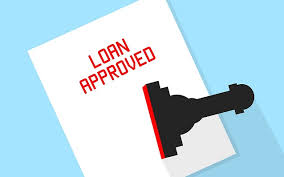

 The goal of this work is to develop a robust, generalisable machine learning model (xgboost) to predict the likelihood of loan defaults for both existing customers and new applicants.

In [ ]:
#pip install optuna

In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import StratifiedGroupKFold, cross_val_score
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, auc, accuracy_score,precision_score,recall_score
from sklearn.model_selection import train_test_split
import xgboost as xgb

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Helper Functions

In [3]:
def calculate_class_weights(y):

    #Function to calculate class weights based on class distribution in the target variable.

    unique_classes, class_counts = np.unique(y, return_counts=True)
    total_samples = len(y)
    class_weights = {}

    for class_label, class_count in zip(unique_classes, class_counts):
        class_weight = total_samples / (2.0 * class_count)
        class_weights[class_label] = class_weight

    return class_weights


In [4]:
def plot_confusion_matrix(y_true, y_pred, class_names, figsize=(8, 6)):

    #Visualize the confusion matrix for model evaluation.

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=figsize)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()


In [5]:
def stratified_groupkfold_cv(model, X, y, groups, n_splits=None, class_weights=None, verbose=False):

    sgkf = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=65)
    f1_scores = []

    for fold, (train_index, test_index) in enumerate(sgkf.split(X, y, groups)):
        if verbose:
            print(f"Fold {fold+1}/{n_splits}")

        # Split the data into training and testing sets
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Initialize the model with class weights if provided
        if class_weights:
            model.set_params(class_weight=class_weights)

        model.fit(X_train, y_train)

        # Make predictions and evaluate F1 score
        preds = model.predict(X_test)
        f1 = f1_score(y_test, preds)
        f1_scores.append(f1)

        if verbose:
            print(f"F1 Score: {f1:.4f}")

    mean_f1_score = np.mean(f1_scores)
    if verbose:
        print(f"Mean F1 Score: {mean_f1_score:.4f}")

    return mean_f1_score


In [6]:
def visualize_feature_importance(model, feature_names, top_n=25):

    # Extract feature importances
    importance = model.feature_importances_

    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance
    }).sort_values(by='Importance', ascending=False)

    top_features = importance_df.head(top_n)

    plt.figure(figsize=(10, 6))
    plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title(f'Top {top_n} Feature Importances')
    plt.gca().invert_yaxis()  # Invert y-axis to show the most important at the top
    plt.show()


In [7]:
data1 = pd.read_csv("/content/drive/MyDrive/African Credit score Challenge/Train.csv", low_memory=False)
data2 = pd.read_csv("/content/drive/MyDrive/African Credit score Challenge/Test.csv", low_memory=False)
data3 = pd.read_csv("/content/drive/MyDrive/African Credit score Challenge/SampleSubmission.csv")
data4 = pd.read_csv("/content/drive/MyDrive/African Credit score Challenge/economic_indicators.csv")

display('Train_df', data1.head(), "Test_df", data2.head(), "economic_indicator_df", data4.head())

'Train_df'

,ID,customer_id,country_id,tbl_loan_id,lender_id,loan_type,Total_Amount,Total_Amount_to_Repay,disbursement_date,due_date,duration,New_versus_Repeat,Amount_Funded_By_Lender,Lender_portion_Funded,Lender_portion_to_be_repaid,target
0,ID_266671248032267278,266671,Kenya,248032,267278,Type_1,8448.0,8448.0,2022-08-30,2022-09-06,7,Repeat Loan,120.85,0.014305,121.0,0
1,ID_248919228515267278,248919,Kenya,228515,267278,Type_1,25895.0,25979.0,2022-07-30,2022-08-06,7,Repeat Loan,7768.50,0.300000,7794.0,0
2,ID_308486370501251804,308486,Kenya,370501,251804,Type_7,6900.0,7142.0,2024-09-06,2024-09-13,7,Repeat Loan,1380.00,0.200000,1428.0,0
3,ID_266004285009267278,266004,Kenya,285009,267278,Type_1,8958.0,9233.0,2022-10-20,2022-10-27,7,Repeat Loan,2687.40,0.300000,2770.0,0
4,ID_253803305312267278,253803,Kenya,305312,267278,Type_1,4564.0,4728.0,2022-11-28,2022-12-05,7,Repeat Loan,1369.20,0.300000,1418.0,0


'Test_df'

,ID,customer_id,country_id,tbl_loan_id,lender_id,loan_type,Total_Amount,Total_Amount_to_Repay,disbursement_date,due_date,duration,New_versus_Repeat,Amount_Funded_By_Lender,Lender_portion_Funded,Lender_portion_to_be_repaid
0,ID_269404226088267278,269404,Kenya,226088,267278,Type_1,1919.0,1989.0,2022-07-27,2022-08-03,7,Repeat Loan,575.7,0.300000,597.0
1,ID_255356300042267278,255356,Kenya,300042,267278,Type_1,2138.0,2153.0,2022-11-16,2022-11-23,7,Repeat Loan,0.0,0.000000,0.0
2,ID_257026243764267278,257026,Kenya,243764,267278,Type_1,8254.0,8304.0,2022-08-24,2022-08-31,7,Repeat Loan,207.0,0.025079,208.0
3,ID_264617299409267278,264617,Kenya,299409,267278,Type_1,3379.0,3379.0,2022-11-15,2022-11-22,7,Repeat Loan,1013.7,0.300000,1014.0
4,ID_247613296713267278,247613,Kenya,296713,267278,Type_1,120.0,120.0,2022-11-10,2022-11-17,7,Repeat Loan,36.0,0.300000,36.0


'economic_indicator_df'

,Country,Indicator,YR2001,YR2002,YR2003,YR2004,YR2005,YR2006,YR2007,YR2008,...,YR2014,YR2015,YR2016,YR2017,YR2018,YR2019,YR2020,YR2021,YR2022,YR2023
0,Ghana,"Inflation, consumer prices (annual %)",41.509496,9.360932,29.772980,18.042739,15.438992,11.679184,10.734267,16.494640,...,15.489616,17.149970,17.454635,12.371922,7.808765,7.143640,9.887290,9.971089,31.255895,38.106966
1,Cote d'Ivoire,"Inflation, consumer prices (annual %)",4.361529,3.077265,3.296807,1.457988,3.885830,2.467191,1.892006,6.308528,...,0.448682,1.251500,0.723178,0.685881,0.359409,-1.106863,2.425007,4.091952,5.276167,4.387117
2,Kenya,"Inflation, consumer prices (annual %)",5.738598,1.961308,9.815691,11.624036,10.312778,14.453734,9.758880,26.239817,...,6.878155,6.582154,6.297250,8.005650,4.689806,5.239638,5.405162,6.107936,7.659863,7.671396
3,Ghana,"Official exchange rate (LCU per US$, period av...",0.716305,0.792417,0.866764,0.899495,0.905209,0.915107,0.932619,1.052275,...,2.896575,3.714642,3.909817,4.350533,4.585325,5.217367,5.595708,5.805700,8.272400,11.020408
4,Cote d'Ivoire,"Official exchange rate (LCU per US$, period av...",732.397693,693.713226,579.897426,527.338032,527.258363,522.425625,478.633718,446.000041,...,493.757330,591.211698,592.605615,580.656750,555.446458,585.911013,575.586005,554.530675,623.759701,606.569750


In [8]:
#create a copy of the datasets
df1 = data1.copy()
df2 = data2.copy()
df3 = data3.copy()
df4 = data4.copy()

In [9]:
#Descriptive summary of training data

df1.describe().T

,count,mean,std,min,25%,50%,75%,max
customer_id,68654.0,254390.256780,26642.719918,145.0,248945.750000,255361.0,262269.25,3.127370e+05
tbl_loan_id,68654.0,263056.266248,39486.661487,101323.0,233942.250000,260305.5,286962.75,3.753200e+05
lender_id,68654.0,266420.528462,3590.999004,245684.0,267278.000000,267278.0,267278.00,2.672780e+05
Total_Amount,68654.0,14836.828617,141649.868388,2.0,2295.000000,5249.0,11450.00,2.300000e+07
Total_Amount_to_Repay,68654.0,15639.929901,165078.352830,0.0,2329.000000,5325.0,11650.00,2.541500e+07
duration,68654.0,8.544586,13.343145,1.0,7.000000,7.0,7.00,1.096000e+03
Amount_Funded_By_Lender,68654.0,2545.663204,11922.724169,0.0,234.000000,915.0,2272.65,1.600000e+06
Lender_portion_Funded,68654.0,0.218679,0.129832,0.0,0.118712,0.3,0.30,1.168119e+00
Lender_portion_to_be_repaid,68654.0,2652.621493,13380.063537,0.0,239.000000,934.0,2317.00,1.821338e+06
target,68654.0,0.018324,0.134120,0.0,0.000000,0.0,0.00,1.000000e+00


In [10]:
#code to view how many unique values are in each feature

df1.nunique()

,0
ID,68654
customer_id,6540
country_id,1
tbl_loan_id,66520
lender_id,4
loan_type,22
Total_Amount,19076
Total_Amount_to_Repay,21920
disbursement_date,768
due_date,893


In [9]:
#Loaning an amount of 2 is unrealistic, Let's set the minimum loan amount to 1000

df1 = df1[df1['Total_Amount'] >= 1000]
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 62246 entries, 0 to 68653
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           62246 non-null  object 
 1   customer_id                  62246 non-null  int64  
 2   country_id                   62246 non-null  object 
 3   tbl_loan_id                  62246 non-null  int64  
 4   lender_id                    62246 non-null  int64  
 5   loan_type                    62246 non-null  object 
 6   Total_Amount                 62246 non-null  float64
 7   Total_Amount_to_Repay        62246 non-null  float64
 8   disbursement_date            62246 non-null  object 
 9   due_date                     62246 non-null  object 
 10  duration                     62246 non-null  int64  
 11  New_versus_Repeat            62246 non-null  object 
 12  Amount_Funded_By_Lender      62246 non-null  float64
 13  Lender_portion_Funded

In [10]:
df1 = df1[df1['Total_Amount_to_Repay'] >= 1000]
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 62242 entries, 0 to 68653
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           62242 non-null  object 
 1   customer_id                  62242 non-null  int64  
 2   country_id                   62242 non-null  object 
 3   tbl_loan_id                  62242 non-null  int64  
 4   lender_id                    62242 non-null  int64  
 5   loan_type                    62242 non-null  object 
 6   Total_Amount                 62242 non-null  float64
 7   Total_Amount_to_Repay        62242 non-null  float64
 8   disbursement_date            62242 non-null  object 
 9   due_date                     62242 non-null  object 
 10  duration                     62242 non-null  int64  
 11  New_versus_Repeat            62242 non-null  object 
 12  Amount_Funded_By_Lender      62242 non-null  float64
 13  Lender_portion_Funded

In [11]:
#convert disbursement data and due date to datetime dtype

df1['disbursement_date'] = pd.to_datetime(df1['disbursement_date'])
df1['due_date'] = pd.to_datetime(df1['due_date'])

df2['disbursement_date'] = pd.to_datetime(df2['disbursement_date'])
df2['due_date'] = pd.to_datetime(df2['due_date'])

# Exploratory Data Analysis

In [14]:
#check if there are common entries between train and test set
train_set = set(zip(df1['customer_id'], df1['tbl_loan_id'], df1['lender_id']))
test_set = set(zip(df2['customer_id'], df2['tbl_loan_id'], df2['lender_id']))

# Find the intersection (common entries) between the train and test datasets
common_entries = train_set.intersection(test_set)

if common_entries:
    print(f"Found {len(common_entries)} common entries between train and test datasets:")
    for entry in common_entries:
        print(entry)
else:
    print("No common entries found between train and test datasets.")

No common entries found between train and test datasets.


In [15]:
#Target distribution
df1['target'].value_counts()

,count
target,
0,61046
1,1196


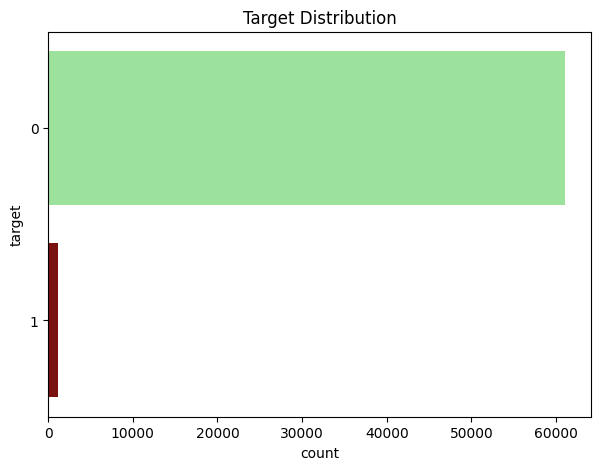

In [18]:
# countplot to visualize target class distribution
plt.figure(figsize=(7,5))
sns.countplot(y='target', data= df1, palette={'0': 'lightgreen', '1': 'darkred'})
plt.title('Target Distribution')
plt.show()

#### **There is a high class imbalance in the target feature.**

Over the years, the majority of Zecron customers have consistently honored their loan obligations, with only a small proportion defaulting.

**P.S:** *Zecron here is just a fictional name of the financial institution*

In [19]:
#Group the features into Categorical and Numerical features

categorical_features = ['loan_type', 'New_versus_Repeat', 'lender_id']
Numerical_features = ['Total_Amount', 'Total_Amount_to_Repay','Amount_Funded_By_Lender', 'Lender_portion_Funded',
       'Lender_portion_to_be_repaid']


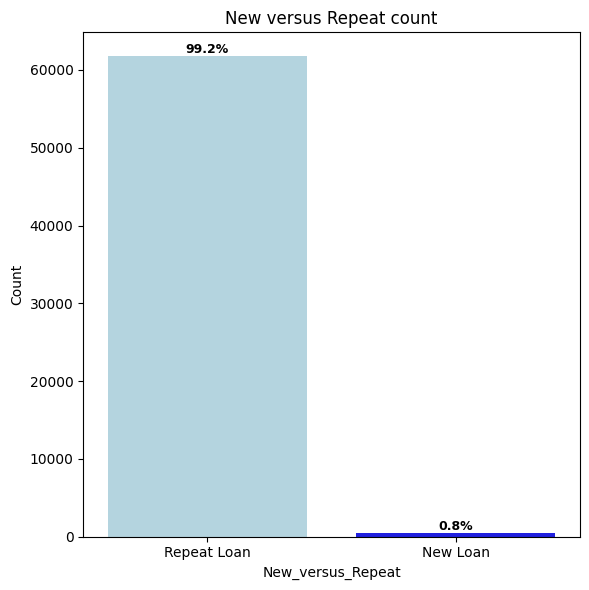

In [23]:
# countplot to visualize the distribution of old and first time customers

fig, axes = plt.subplots(1, 1, figsize=(6, 6))

column = 'New_versus_Repeat'
title = 'New versus Repeat count'

sns.countplot(x=column, data=df1, ax=axes, palette={'Repeat Loan': 'lightblue', 'New Loan': 'blue'})
axes.set_title(title)
axes.set_xlabel(column)
axes.set_ylabel('Count')

# Add percentage values on top of each bar
total = len(df1[column])
for p in axes.patches:
    height = p.get_height()
    percentage = f'{100 * height / total:.1f}%'
    axes.annotate(percentage, (p.get_x() + p.get_width() / 2, height),
                  ha='center', va='bottom', fontsize=9, color='black', fontweight='bold')

plt.tight_layout()
plt.show()


99.2% of Zecron customers are repeat borrowers, demonstrating strong trust in their services and consistent engagement with their offerings. In contrast, only 0.8% are first-time borrowers, highlighting a smaller segment of new customers.

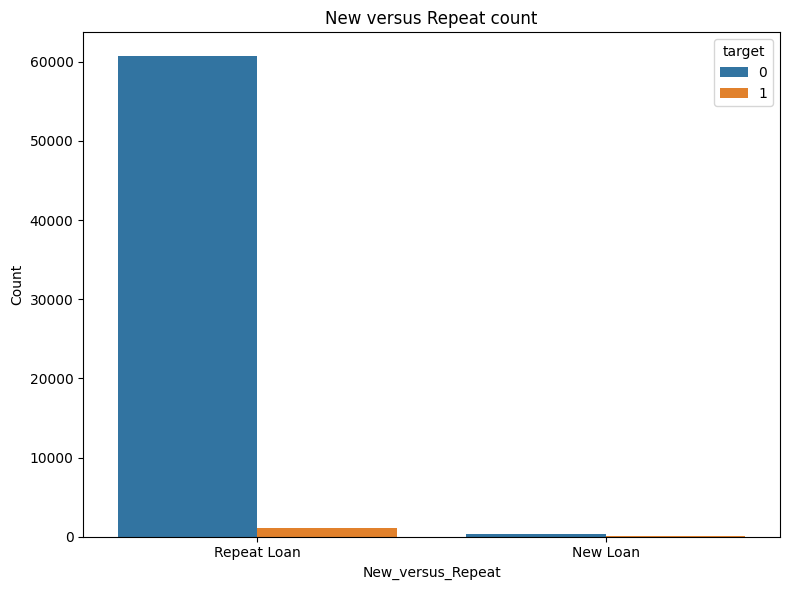

In [25]:
#count plot to visualize the fraction of customers who defaulted their loans in both Repeated Loan and New Loan category

fig, axes = plt.subplots(1, 1, figsize=(8, 6))

column = 'New_versus_Repeat'
title = 'New versus Repeat count'

sns.countplot(x=column, hue='target', data=df1, ax=axes)
axes.set_title(title)
axes.set_xlabel(column)
axes.set_ylabel('Count')


plt.tight_layout()
plt.show()

Across both Repeat Loan customers and New Loan customers, only a small fraction default on their loans.

In [26]:
#Let's see how many customers who took different loan types defaulted on their loans

value_num = df1[df1['target']==1].groupby('loan_type')['target'].count()
value_num

,target
loan_type,
Type_1,465
Type_10,12
Type_11,2
Type_12,1
Type_14,71
Type_15,3
Type_18,1
Type_2,45
Type_20,7


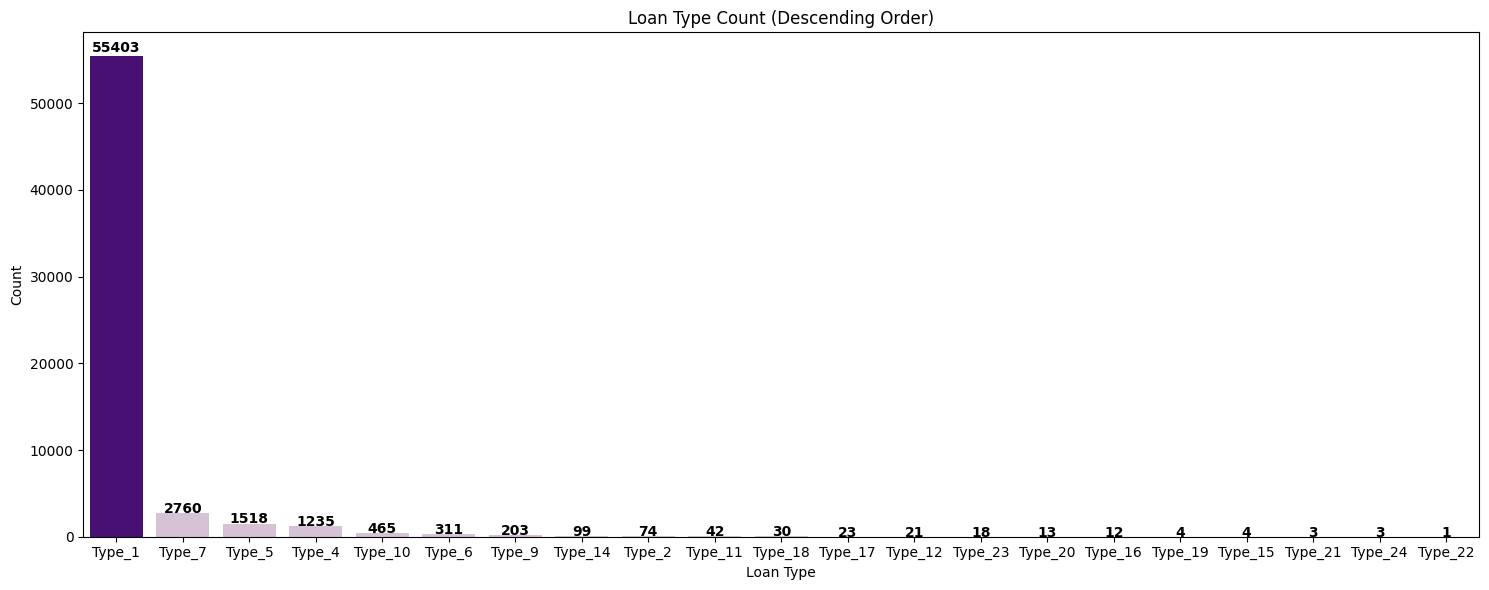

In [27]:
#Lets see the number of customers that took each loan type

# Calculate the count for each loan type
loan_type_counts = df1['loan_type'].value_counts()

# Convert to a DataFrame for sorting
loan_type_counts = loan_type_counts.sort_values(ascending=False)

# Create the color palette
colors = ['#4B0082'] + ['#D8BFD8'] * (len(loan_type_counts) - 1)
# Dark purple for the first bar, lighter purple for the rest

# Create the plot
fig, axes = plt.subplots(1, 1, figsize=(15, 6))

sns.barplot(x=loan_type_counts.index, y=loan_type_counts.values, ax=axes, palette=colors)
axes.set_title('Loan Type Count (Descending Order)')
axes.set_xlabel('Loan Type')
axes.set_ylabel('Count')

# Add annotations for the count above each bar
for i, val in enumerate(loan_type_counts.values):
    axes.text(i, val + 0.01 * val, f'{val}', ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()


 This plot reveals that Type 1 loans are significantly more popular among our customers compared to other loan types.

 This indicates a higher demand or alignment of Type 1 loans with customer needs.

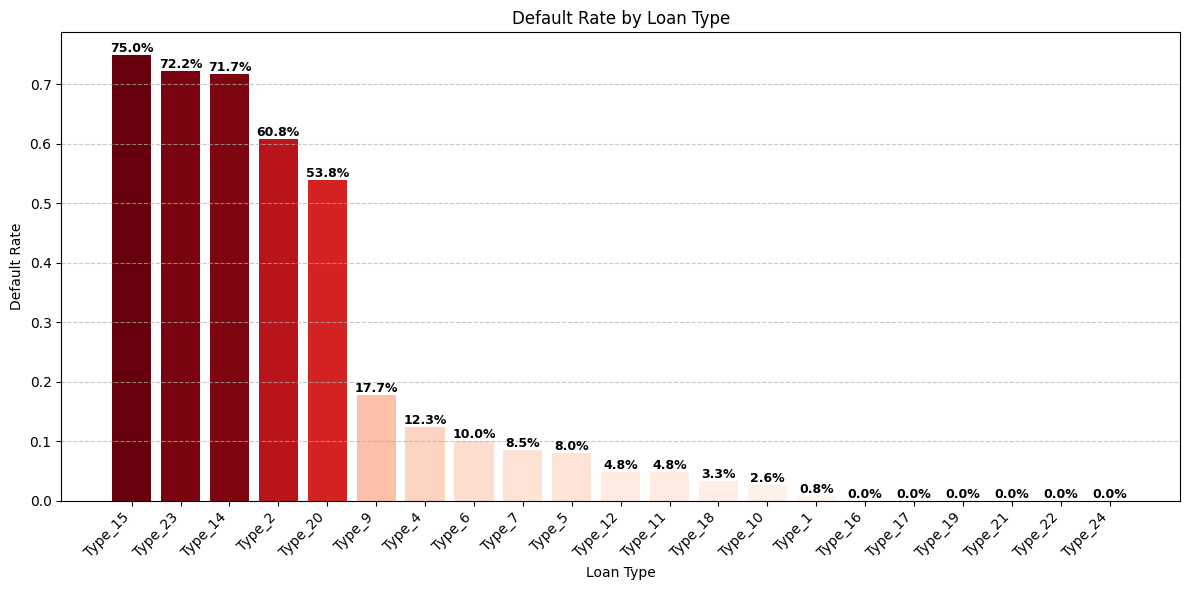

In [28]:
#Lets visualize the percentage of customers that defaulted on each loan type

# Calculate default rate for each loan type
loan_type_default_rate = df1.groupby('loan_type')['target'].mean()

# Sort by default rate for better visualization
loan_type_default_rate = loan_type_default_rate.sort_values(ascending=False)

# Create a colormap where the color fades as the bar height gets smaller
norm = plt.Normalize(loan_type_default_rate.min(), loan_type_default_rate.max())
cmap = plt.cm.Reds

# Plot Default Rate by Loan Type
plt.figure(figsize=(12, 6))
bars = plt.bar(loan_type_default_rate.index, loan_type_default_rate.values, color=cmap(norm(loan_type_default_rate.values)))
#loan_type_default_rate.plot(kind='bar', color='skyblue')
plt.title('Default Rate by Loan Type')
plt.xlabel('Loan Type')
plt.ylabel('Default Rate')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add percentage annotations
for p in bars:
    height = p.get_height()
    percentage = f'{100 * height:.1f}%'
    plt.gca().annotate(percentage, (p.get_x() + p.get_width() / 2, height),
                       ha='center', va='bottom', fontsize=9, color='black', fontweight='bold')

plt.tight_layout()
plt.show()


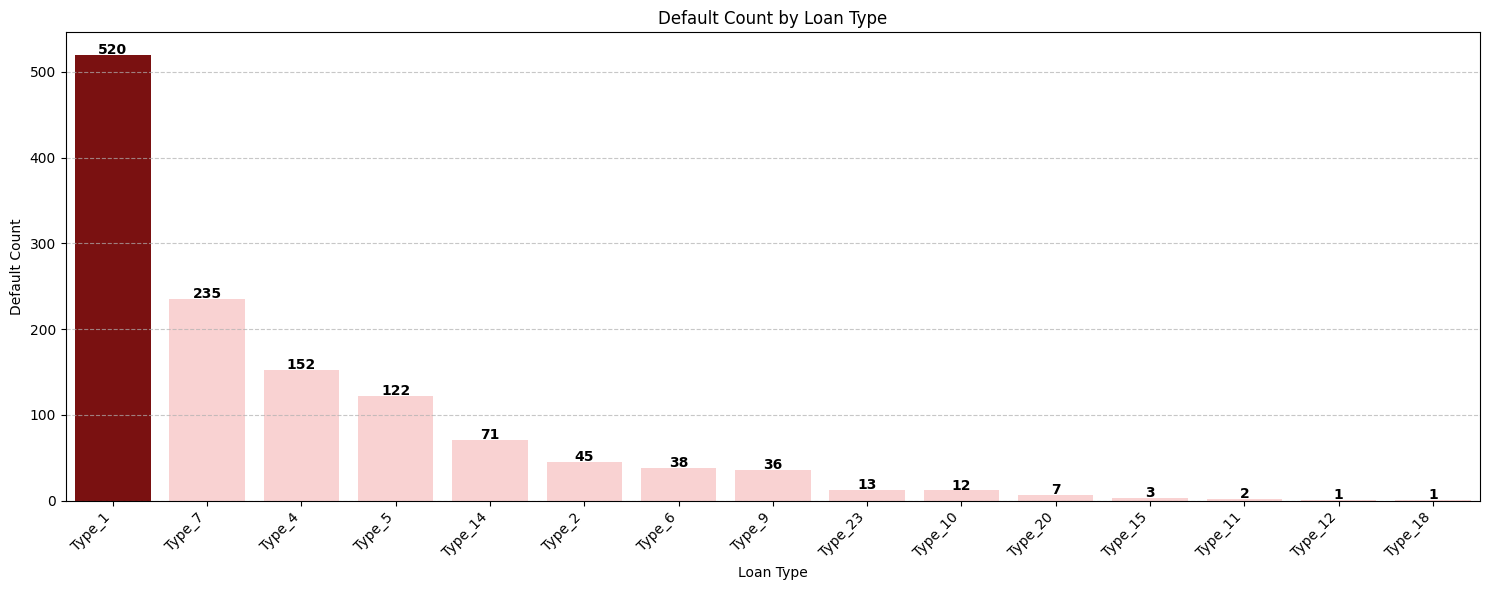

In [13]:
#Lets visualize the number of customers that defaulted on each loan type

# Calculate total defaults for each loan type
loan_type_default_count = df1[df1['target'] == 1].groupby('loan_type')['target'].count()

# Sort by default count for better visualization
loan_type_default_count = loan_type_default_count.sort_values(ascending=False)

colors = ['#8B0000'] + ['#FFCCCC'] * (len(loan_type_default_count) - 1)

# Plot Default Count by Loan Type
# Create the plot
fig, axes = plt.subplots(1, 1, figsize=(15, 6))
sns.barplot(x=loan_type_default_count.index, y=loan_type_default_count.values, ax=axes, palette=colors)
#loan_type_default_count.plot(kind='bar', color='skyblue')
plt.title('Default Count by Loan Type')
plt.xlabel('Loan Type')
plt.ylabel('Default Count')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add annotations for the default count above each bar
for i, val in enumerate(loan_type_default_count):
    plt.text(i, val + 1, f'{val}', ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()


Loan types A to E have a higher incidence of customer defaults compared to other loan types. However, it is important to note that these loan types are being utilized by only a small number of customers. This means that, while the default rate is relatively high for these loans, the overall impact on the portfolio may be less significant due to the smaller customer base.

In [ ]:
#lender_loan_counts.T

lender_id,245684,251804,267277,267278
loan_type,,,,
Type_1,0,0,0,39933
Type_10,0,252,0,200
Type_11,32,0,0,1
Type_12,21,0,0,0
Type_14,98,0,0,0
Type_15,1,0,3,0
Type_16,0,6,0,6
Type_17,0,10,0,13
Type_18,0,15,0,0


In [14]:
# Filter data for defaults (target = 1)
defaulted = df1[df1['target'] == 1]

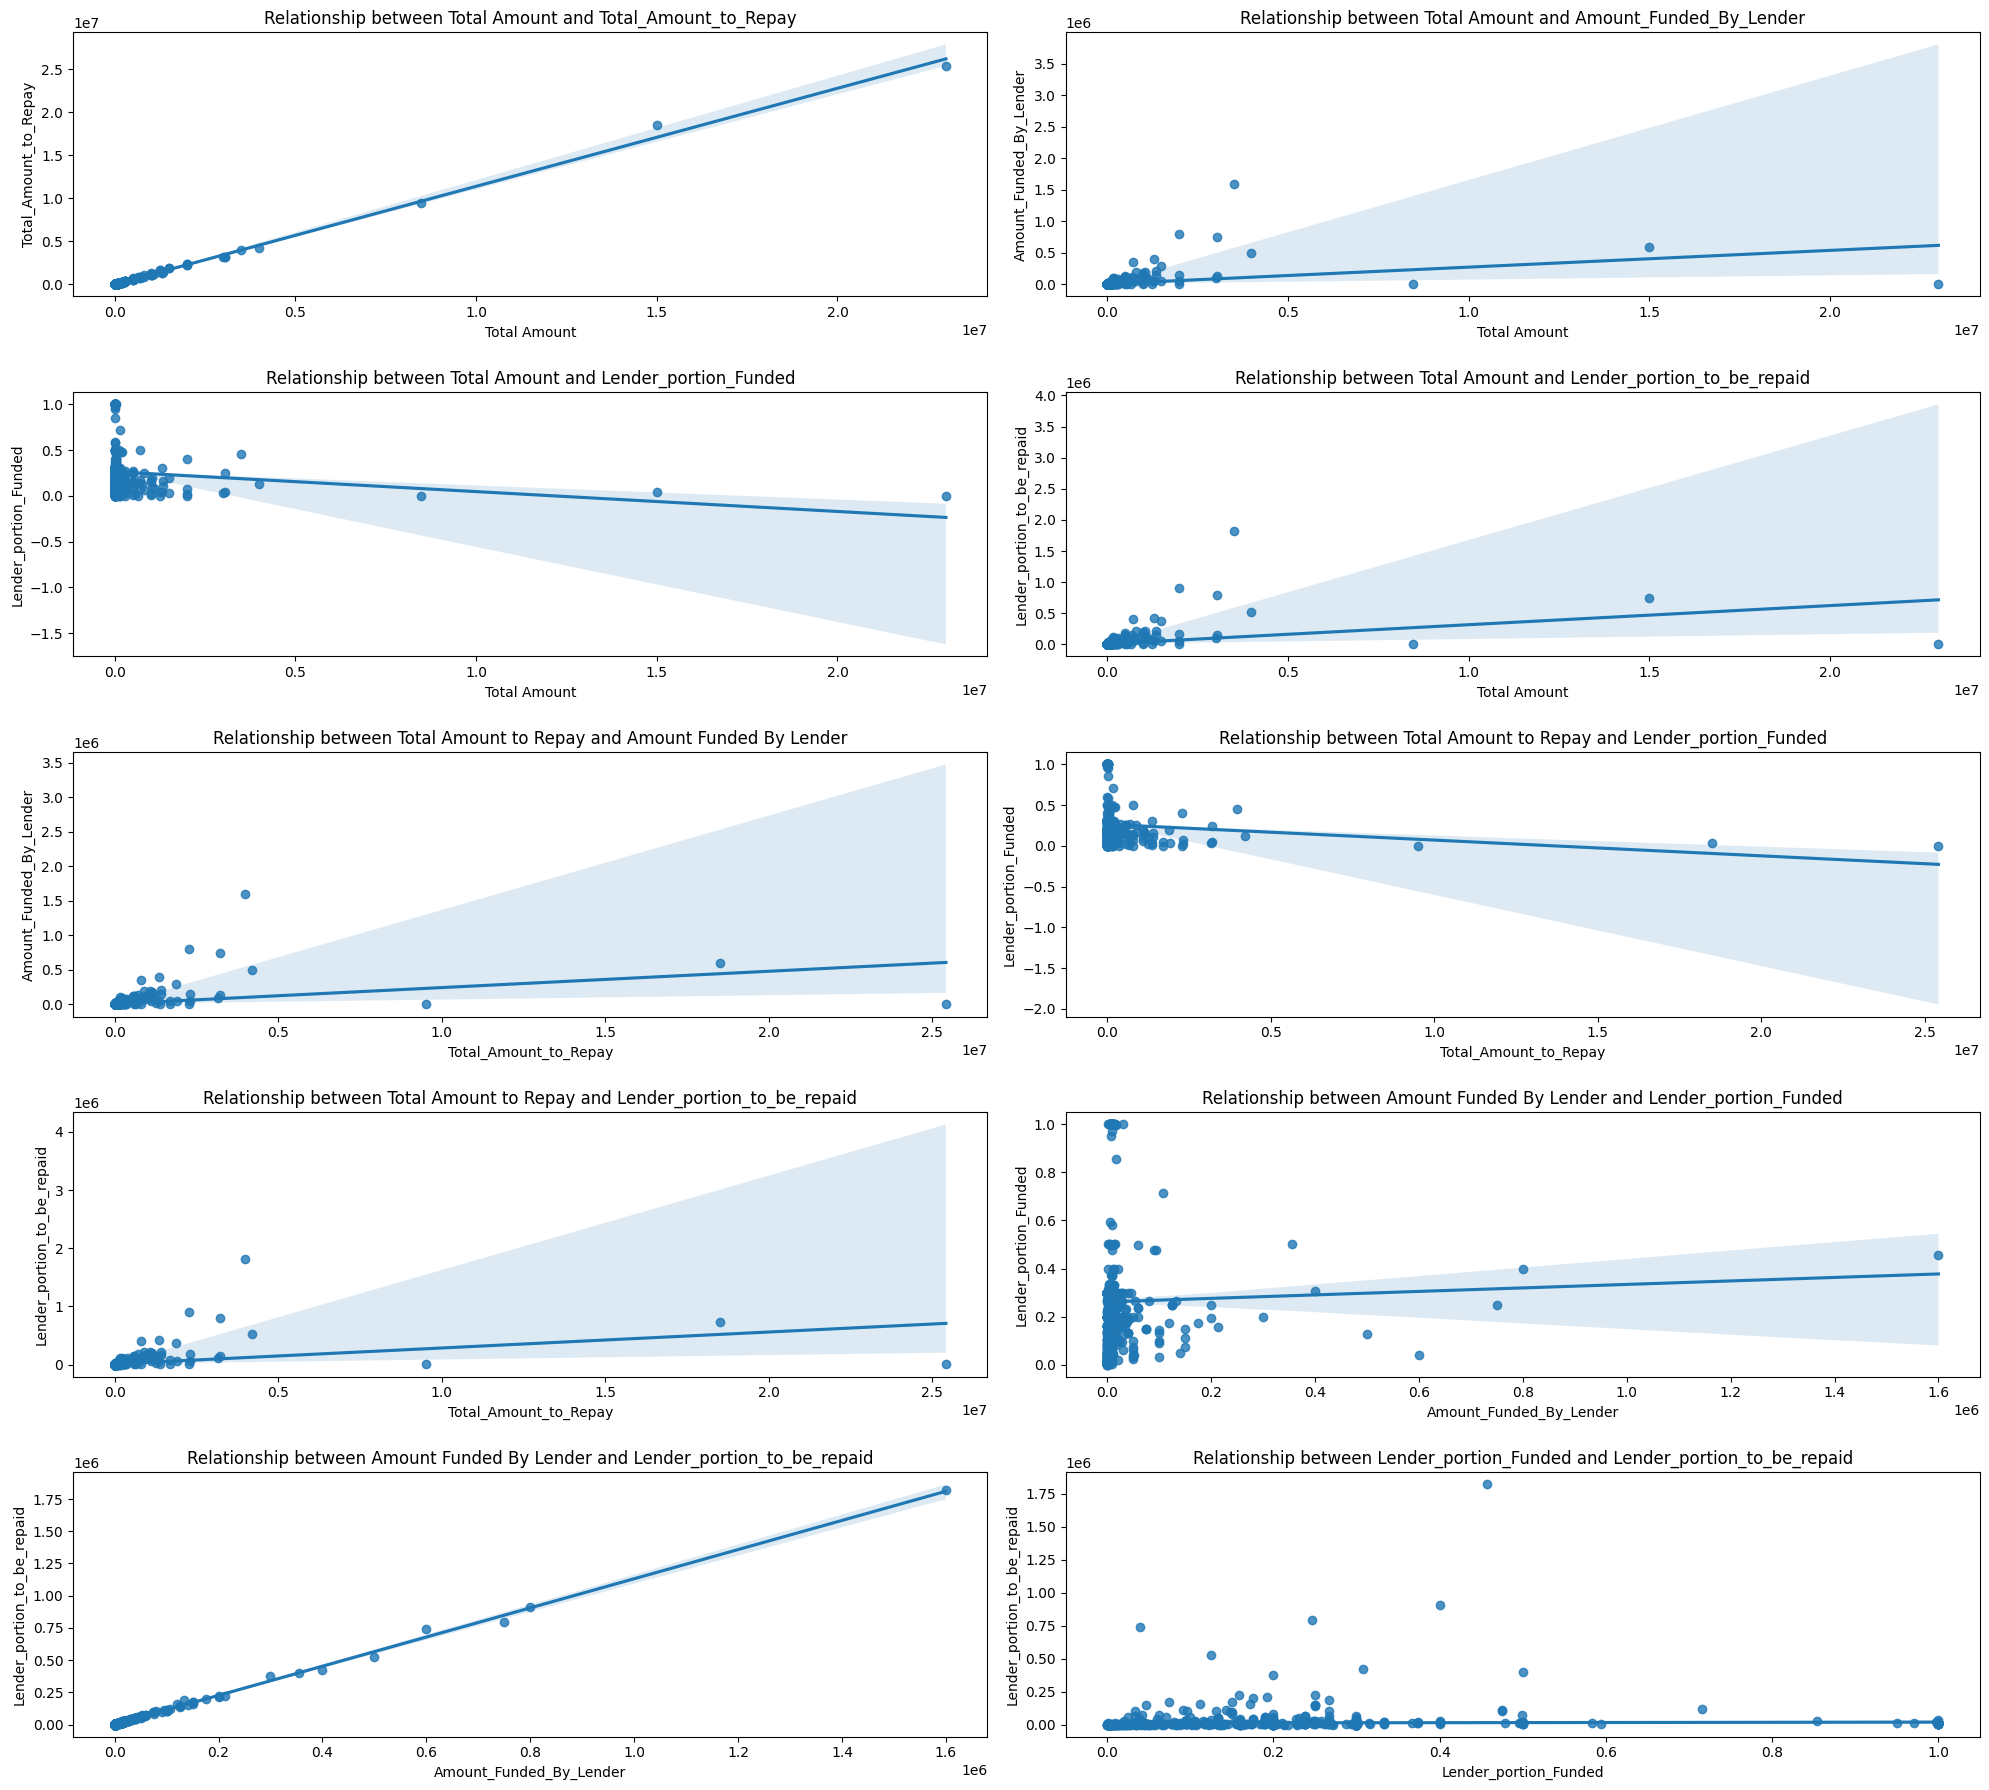

In [15]:
#Visualize the relationships between Numerical features of the defaulted customers

fig, axes = plt.subplots(5,2, figsize=(20,18))

sns.regplot(data=defaulted, x='Total_Amount', y='Total_Amount_to_Repay', ax=axes[0,0])
axes[0,0].set_xlabel('Total Amount')
axes[0,0].set_ylabel('Total_Amount_to_Repay')
axes[0,0].set_title('Relationship between Total Amount and Total_Amount_to_Repay')

sns.regplot(data=defaulted, x='Total_Amount', y='Amount_Funded_By_Lender', ax=axes[0,1])
axes[0,1].set_xlabel('Total Amount')
axes[0,1].set_ylabel('Amount_Funded_By_Lender')
axes[0,1].set_title('Relationship between Total Amount and Amount_Funded_By_Lender')

sns.regplot(data=defaulted, x='Total_Amount', y='Lender_portion_Funded', ax=axes[1,0])
axes[1,0].set_xlabel('Total Amount')
axes[1,0].set_ylabel('Lender_portion_Funded')
axes[1,0].set_title('Relationship between Total Amount and Lender_portion_Funded')

sns.regplot(data=defaulted, x='Total_Amount', y='Lender_portion_to_be_repaid', ax=axes[1,1])
axes[1,1].set_xlabel('Total Amount')
axes[1,1].set_ylabel('Lender_portion_to_be_repaid')
axes[1,1].set_title('Relationship between Total Amount and Lender_portion_to_be_repaid')

sns.regplot(data=defaulted, x='Total_Amount_to_Repay', y='Amount_Funded_By_Lender',ax=axes[2,0])
axes[2,0].set_xlabel('Total_Amount_to_Repay')
axes[2,0].set_ylabel('Amount_Funded_By_Lender')
axes[2,0].set_title('Relationship between Total Amount to Repay and Amount Funded By Lender')

sns.regplot(data=defaulted, x='Total_Amount_to_Repay', y='Lender_portion_Funded', ax=axes[2,1])
axes[2,1].set_xlabel('Total_Amount_to_Repay')
axes[2,1].set_ylabel('Lender_portion_Funded')
axes[2,1].set_title('Relationship between Total Amount to Repay and Lender_portion_Funded')

sns.regplot(data=defaulted, x='Total_Amount_to_Repay', y='Lender_portion_to_be_repaid', ax=axes[3,0])
axes[3,0].set_xlabel('Total_Amount_to_Repay')
axes[3,0].set_ylabel('Lender_portion_to_be_repaid')
axes[3,0].set_title('Relationship between Total Amount to Repay and Lender_portion_to_be_repaid')

sns.regplot(data=defaulted, x='Amount_Funded_By_Lender', y='Lender_portion_Funded', ax=axes[3,1])
axes[3,1].set_xlabel('Amount_Funded_By_Lender')
axes[3,1].set_ylabel('Lender_portion_Funded')
axes[3,1].set_title('Relationship between Amount Funded By Lender and Lender_portion_Funded')

sns.regplot(data=defaulted, x='Amount_Funded_By_Lender', y='Lender_portion_to_be_repaid', ax=axes[4,0])
axes[4,0].set_xlabel('Amount_Funded_By_Lender')
axes[4,0].set_ylabel('Lender_portion_to_be_repaid')
axes[4,0].set_title('Relationship between Amount Funded By Lender and Lender_portion_to_be_repaid')

sns.regplot(data=defaulted, x='Lender_portion_Funded', y='Lender_portion_to_be_repaid', ax=axes[4,1])
axes[4,1].set_xlabel('Lender_portion_Funded')
axes[4,1].set_ylabel('Lender_portion_to_be_repaid')
axes[4,1].set_title('Relationship between Lender_portion_Funded and Lender_portion_to_be_repaid')

plt.tight_layout()
plt.show()


In [16]:
non_defaulted = df1[df1['target']==0]

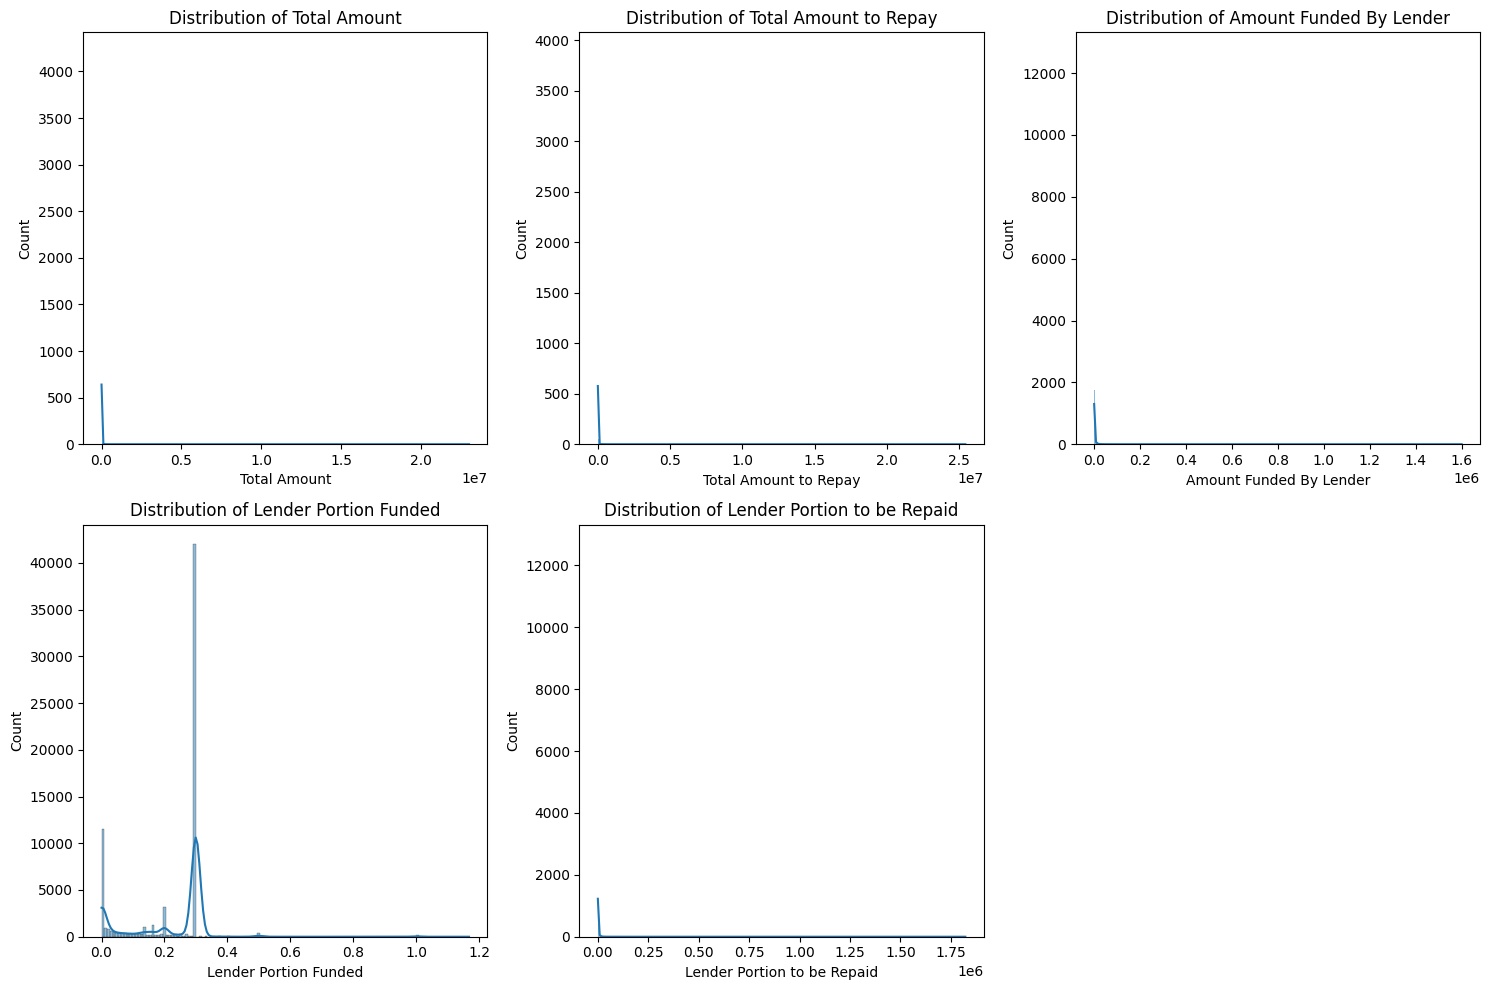

In [18]:
#Visualize feature distributions

fig, axes = plt.subplots(2,3, figsize=(15,10))

sns.histplot(df1['Total_Amount'], kde=True, ax=axes[0,0])
axes[0,0].set_xlabel('Total Amount')
axes[0,0].set_ylabel('Count')
axes[0,0].set_title('Distribution of Total Amount')

sns.histplot(df1['Total_Amount_to_Repay'], kde=True, ax=axes[0,1])
axes[0,1].set_xlabel('Total Amount to Repay')
axes[0,1].set_ylabel('Count')
axes[0,1].set_title('Distribution of Total Amount to Repay')

sns.histplot(df1['Amount_Funded_By_Lender'], kde=True, ax=axes[0,2])
axes[0,2].set_xlabel('Amount Funded By Lender')
axes[0,2].set_ylabel('Count')
axes[0,2].set_title('Distribution of Amount Funded By Lender')

sns.histplot(df1['Lender_portion_Funded'], kde=True, ax=axes[1,0])
axes[1,0].set_xlabel('Lender Portion Funded')
axes[1,0].set_ylabel('Count')
axes[1,0].set_title('Distribution of Lender Portion Funded')

sns.histplot(df1['Lender_portion_to_be_repaid'], kde=True, ax=axes[1,1])
axes[1,1].set_xlabel('Lender Portion to be Repaid')
axes[1,1].set_ylabel('Count')
axes[1,1].set_title('Distribution of Lender Portion to be Repaid')

axes[1,2].axis('off')
plt.tight_layout()
plt.show()

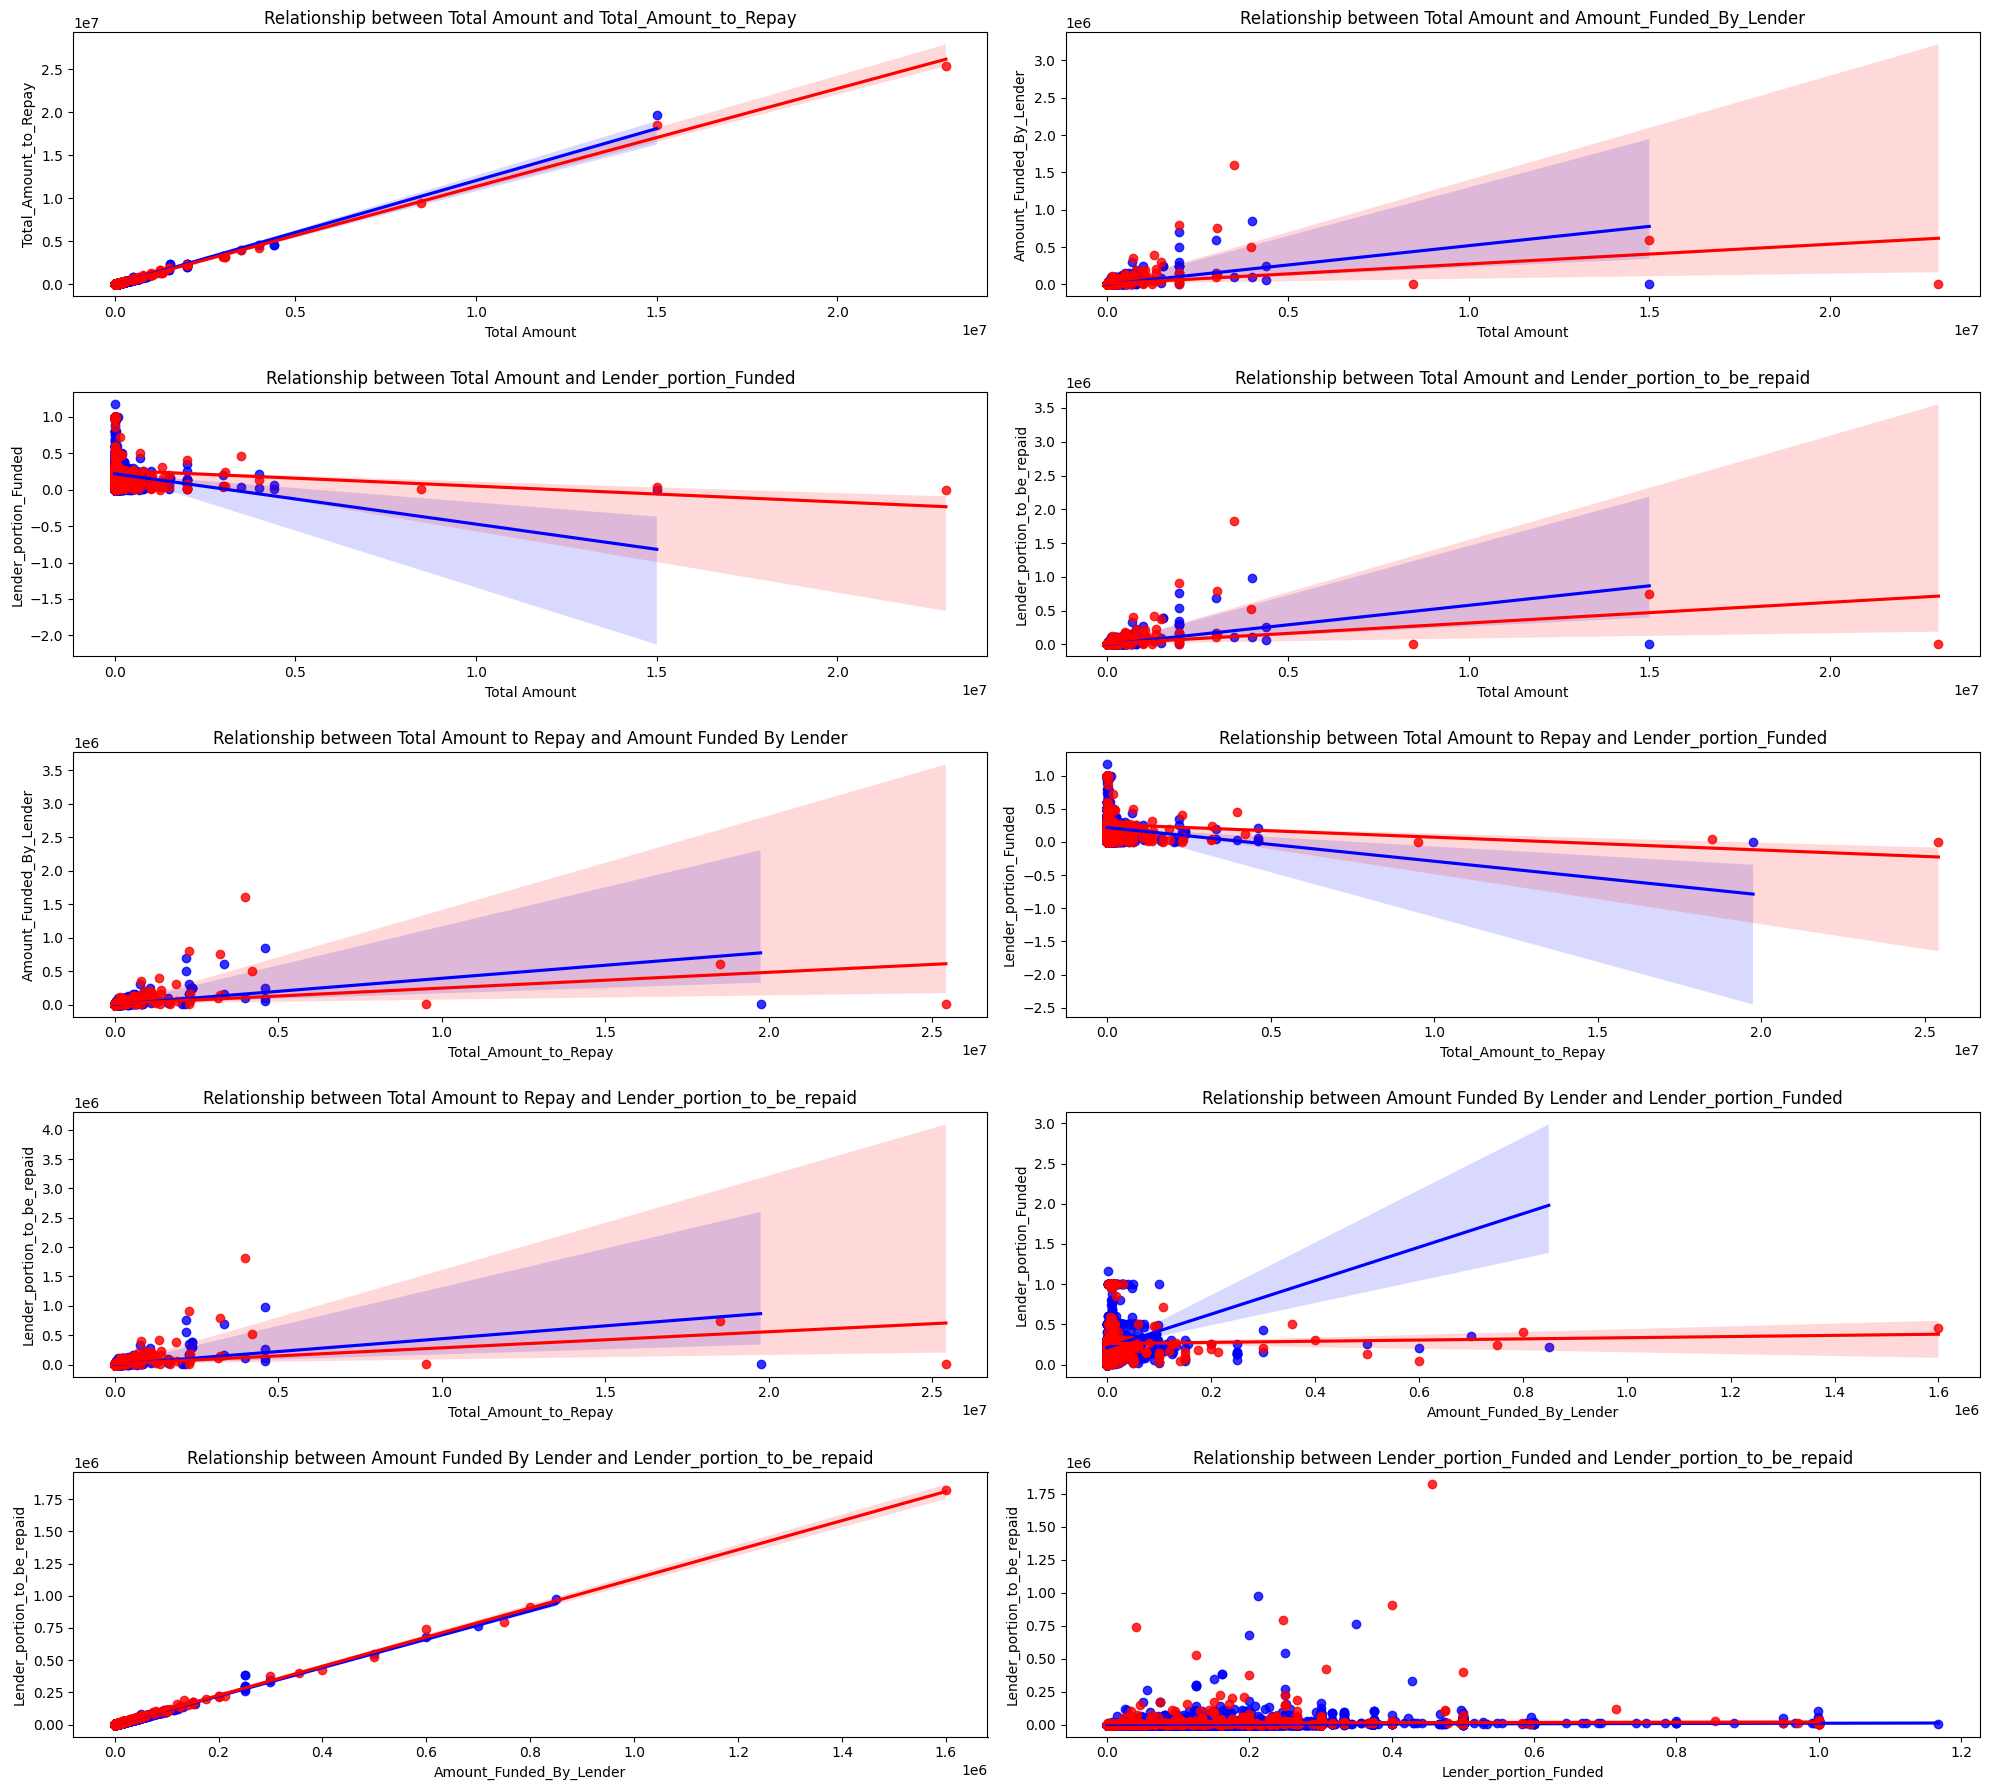

In [ ]:
#Visualize the relationships between Numerical features based on target

fig, axes = plt.subplots(5,2, figsize=(20,18))

sns.regplot(x='Total_Amount', y='Total_Amount_to_Repay', data=df1[df1['target']==0], ax=axes[0,0], color='blue', label='Non-Defaulters')
sns.regplot(x='Total_Amount', y='Total_Amount_to_Repay', data=df1[df1['target']==1], ax=axes[0,0], color='red', label='Defaulters')
axes[0,0].set_xlabel('Total Amount')
axes[0,0].set_ylabel('Total_Amount_to_Repay')
axes[0,0].set_title('Relationship between Total Amount and Total_Amount_to_Repay')

sns.regplot(x='Total_Amount', y='Amount_Funded_By_Lender', data=df1[df1['target']==0], ax=axes[0,1], color='blue', label='Non-Defaulters')
sns.regplot(x='Total_Amount', y='Amount_Funded_By_Lender', data=df1[df1['target']==1], ax=axes[0,1], color='red', label='Defaulters')
axes[0,1].set_xlabel('Total Amount')
axes[0,1].set_ylabel('Amount_Funded_By_Lender')
axes[0,1].set_title('Relationship between Total Amount and Amount_Funded_By_Lender')

sns.regplot(x='Total_Amount', y='Lender_portion_Funded', data=df1[df1['target']==0], ax=axes[1,0], color='blue', label='Non-Defaulters')
sns.regplot(x='Total_Amount', y='Lender_portion_Funded', data=df1[df1['target']==1], ax=axes[1,0], color='red', label='Defaulters')
axes[1,0].set_xlabel('Total Amount')
axes[1,0].set_ylabel('Lender_portion_Funded')
axes[1,0].set_title('Relationship between Total Amount and Lender_portion_Funded')

sns.regplot(x='Total_Amount', y='Lender_portion_to_be_repaid', data=df1[df1['target']==0], ax=axes[1,1], color='blue', label='Non-Defaulters')
sns.regplot(x='Total_Amount', y='Lender_portion_to_be_repaid', data=df1[df1['target']==1], ax=axes[1,1], color='red', label='Defaulters')
axes[1,1].set_xlabel('Total Amount')
axes[1,1].set_ylabel('Lender_portion_to_be_repaid')
axes[1,1].set_title('Relationship between Total Amount and Lender_portion_to_be_repaid')

sns.regplot(x='Total_Amount_to_Repay', y='Amount_Funded_By_Lender', data=df1[df1['target']==0], ax=axes[2,0], color='blue', label='Non-Defaulters')
sns.regplot(x='Total_Amount_to_Repay', y='Amount_Funded_By_Lender', data=df1[df1['target']==1], ax=axes[2,0], color='red', label='Defaulters')
axes[2,0].set_xlabel('Total_Amount_to_Repay')
axes[2,0].set_ylabel('Amount_Funded_By_Lender')
axes[2,0].set_title('Relationship between Total Amount to Repay and Amount Funded By Lender')

sns.regplot(x='Total_Amount_to_Repay', y='Lender_portion_Funded', data=df1[df1['target']==0], ax=axes[2,1], color='blue', label='Non-Defaulters')
sns.regplot(x='Total_Amount_to_Repay', y='Lender_portion_Funded', data=df1[df1['target']==1], ax=axes[2,1], color='red', label='Defaulters')
axes[2,1].set_xlabel('Total_Amount_to_Repay')
axes[2,1].set_ylabel('Lender_portion_Funded')
axes[2,1].set_title('Relationship between Total Amount to Repay and Lender_portion_Funded')

sns.regplot(x='Total_Amount_to_Repay', y='Lender_portion_to_be_repaid', data=df1[df1['target']==0], ax=axes[3,0], color='blue', label='Non-Defaulters')
sns.regplot(x='Total_Amount_to_Repay', y='Lender_portion_to_be_repaid', data=df1[df1['target']==1], ax=axes[3,0], color='red', label='Defaulters')
axes[3,0].set_xlabel('Total_Amount_to_Repay')
axes[3,0].set_ylabel('Lender_portion_to_be_repaid')
axes[3,0].set_title('Relationship between Total Amount to Repay and Lender_portion_to_be_repaid')

sns.regplot(x='Amount_Funded_By_Lender', y='Lender_portion_Funded', data=df1[df1['target']==0], ax=axes[3,1], color='blue', label='Non-Defaulters')
sns.regplot(x='Amount_Funded_By_Lender', y='Lender_portion_Funded', data=df1[df1['target']==1], ax=axes[3,1], color='red', label='Defaulters')
axes[3,1].set_xlabel('Amount_Funded_By_Lender')
axes[3,1].set_ylabel('Lender_portion_Funded')
axes[3,1].set_title('Relationship between Amount Funded By Lender and Lender_portion_Funded')

sns.regplot(x='Amount_Funded_By_Lender', y='Lender_portion_to_be_repaid', data=df1[df1['target']==0], ax=axes[4,0], color='blue', label='Non-Defaulters')
sns.regplot(x='Amount_Funded_By_Lender', y='Lender_portion_to_be_repaid', data=df1[df1['target']==1], ax=axes[4,0], color='red', label='Defaulters')
axes[4,0].set_xlabel('Amount_Funded_By_Lender')
axes[4,0].set_ylabel('Lender_portion_to_be_repaid')
axes[4,0].set_title('Relationship between Amount Funded By Lender and Lender_portion_to_be_repaid')

sns.regplot(x='Lender_portion_Funded', y='Lender_portion_to_be_repaid', data=df1[df1['target']==0], ax=axes[4,1], color='blue', label='Non-Defaulters')
sns.regplot(x='Lender_portion_Funded', y='Lender_portion_to_be_repaid', data=df1[df1['target']==1], ax=axes[4,1], color='red', label='Defaulters')
axes[4,1].set_xlabel('Lender_portion_Funded')
axes[4,1].set_ylabel('Lender_portion_to_be_repaid')
axes[4,1].set_title('Relationship between Lender_portion_Funded and Lender_portion_to_be_repaid')

plt.tight_layout()
plt.show()


Some features, like the Total Amount Loaned and the Total Amount to be Repaid, Amount funded by lender and Lender portion to be repaid are highly correlated i.e practically mirroring each other. This could be a problem because when two features are this closely related, they risk confusing the model.

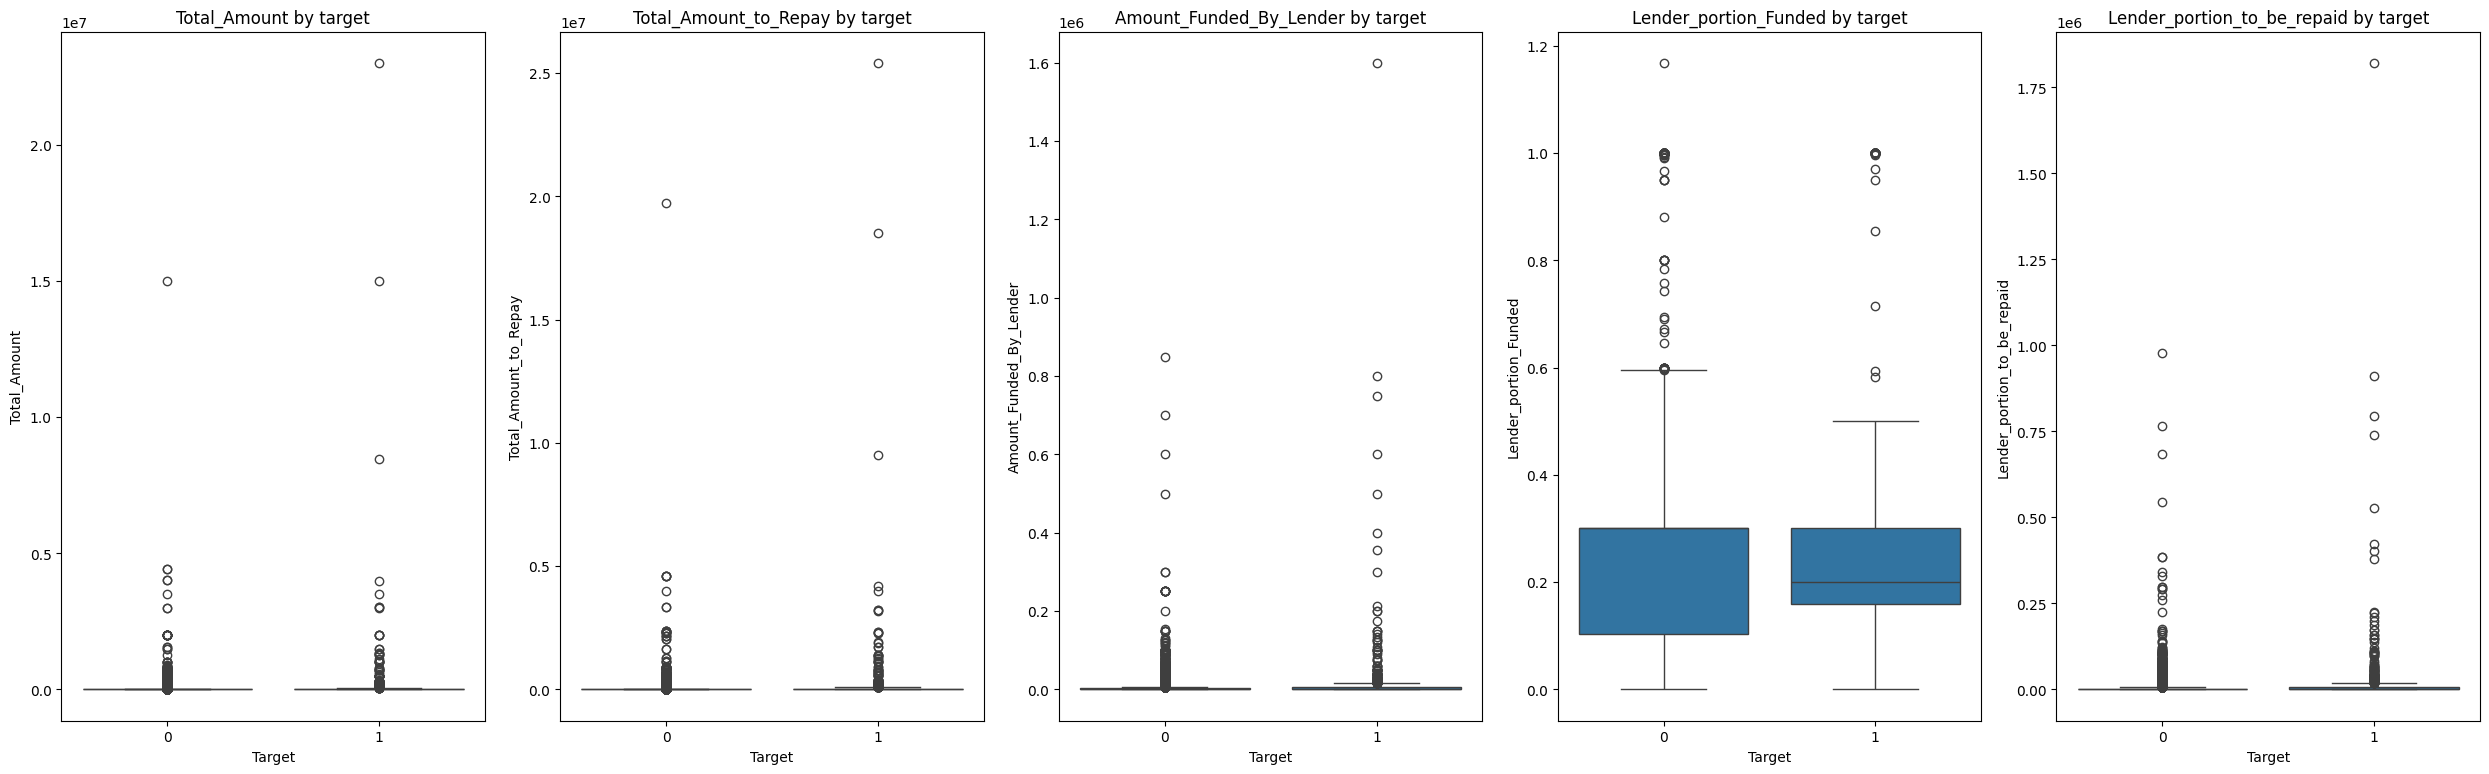

In [ ]:
#box plots to potentially visualize outliers

fig, axes = plt.subplots(1, len(Numerical_features), figsize=(25, 8))

# Loop through each feature and create a box plot
for i, feature in enumerate(Numerical_features):
    sns.boxplot(x='target', y=feature, data=df1, ax=axes[i])
    axes[i].set_title(f'{feature} by target')
    axes[i].set_xlabel('Target')
    axes[i].set_ylabel(feature)

plt.tight_layout()
plt.show()

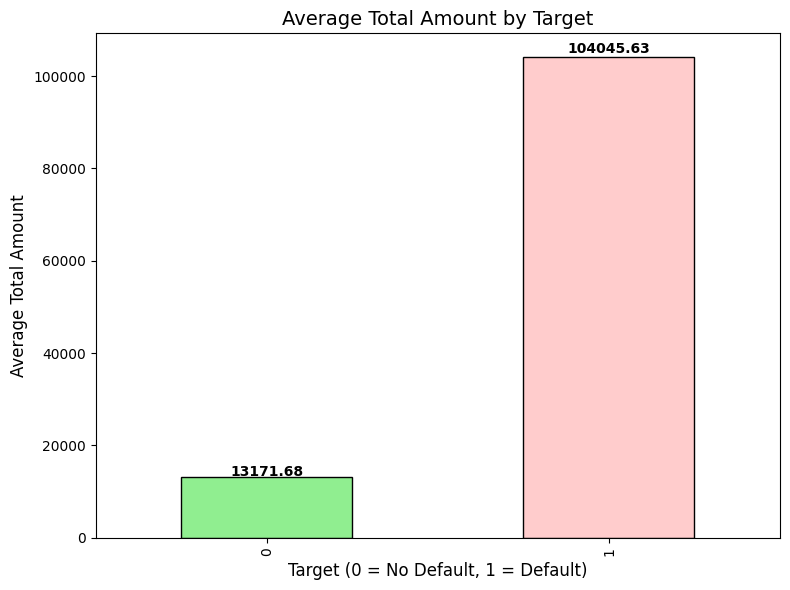

In [20]:
#plot to visualize the average loan amount taken by the 2 categories of customers

# Calculate mean total amount by target
mean_amount = df1.groupby('target')['Total_Amount'].mean()

# Plot the mean total amount as a bar chart
plt.figure(figsize=(8, 6))
mean_amount.plot(kind='bar', color=['lightgreen', '#FFCCCC'], edgecolor='black')

plt.title('Average Total Amount by Target', fontsize=14)
plt.xlabel('Target (0 = No Default, 1 = Default)', fontsize=12)
plt.ylabel('Average Total Amount', fontsize=12)

# Annotate the bars with the median values
for i, val in enumerate(mean_amount):
    plt.text(i, val + 0.01 * val, f'{val:.2f}', ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()


The average loan amount for customers who default is actually higher than for those who manage to pay their loans back. It’s like the customers who found themselves in trouble had taken out bigger loans, only to realize later that they bit off more than they could chew.

This insight is important because it shows us that bigger loans might carry bigger risks. When customers take out larger amounts, the chance of defaulting increases, perhaps because it becomes harder to manage a larger financial burden.

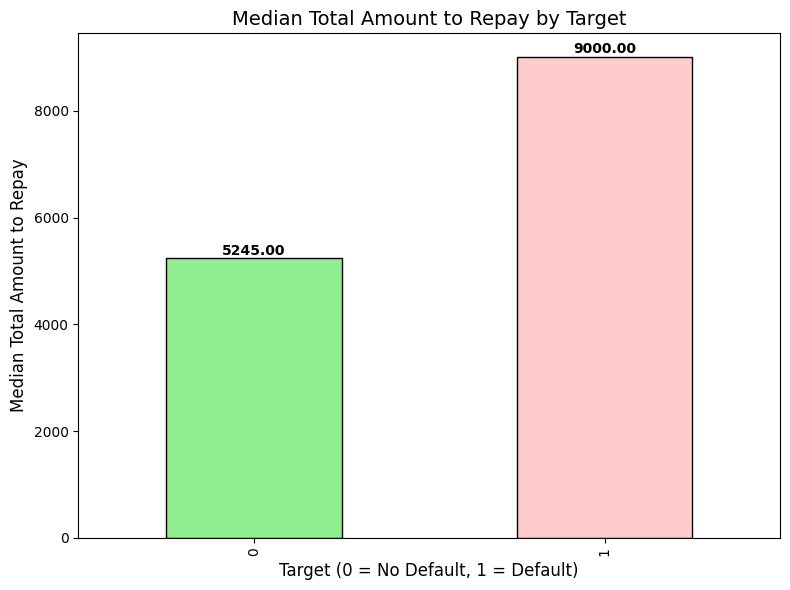

In [21]:
#plot to visualize the median loan amount taken by the 2 categories of customers

# Calculate mean total amount by target
median_amount_to_pay = df1.groupby('target')['Total_Amount'].median()

plt.figure(figsize=(8, 6))
median_amount_to_pay.plot(kind='bar', color=['lightgreen', '#FFCCCC'], edgecolor='black')

plt.title('Median Total Amount to Repay by Target', fontsize=14)
plt.xlabel('Target (0 = No Default, 1 = Default)', fontsize=12)
plt.ylabel('Median Total Amount to Repay', fontsize=12)

# Annotate the bars with the mean values
for i, val in enumerate(median_amount_to_pay):
    plt.text(i, val + 0.01 * val, f'{val:.2f}', ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()


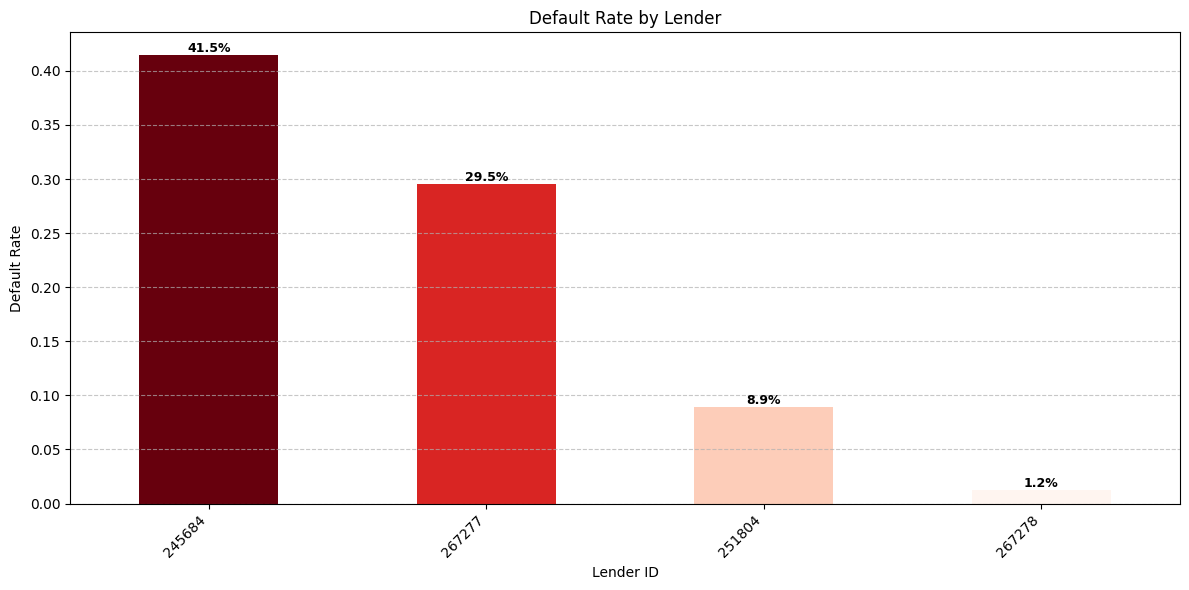

In [25]:
#Lets see the number of times each lender didn't receive their loans from customers

# Calculate default rate for each lender
lender_default_rate = df1.groupby('lender_id')['target'].mean()
lender_default_rate = lender_default_rate.sort_values(ascending=False)

# Create a colormap where the color fades as the default rate gets smaller
norm = plt.Normalize(lender_default_rate.min(), lender_default_rate.max())
cmap = plt.cm.Reds

plt.figure(figsize=(12, 6))
bars = lender_default_rate.plot(kind='bar', color=cmap(norm(lender_default_rate.values)))
plt.title('Default Rate by Lender')
plt.xlabel('Lender ID')
plt.ylabel('Default Rate')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add percentage annotations
for p in plt.gca().patches:
    height = p.get_height()
    percentage = f'{100 * height:.1f}%'
    plt.gca().annotate(percentage, (p.get_x() + p.get_width() / 2, height),
                       ha='center', va='bottom', fontsize=9, color='black', fontweight='bold')

plt.tight_layout()
plt.show()


Lender 267278 attracts the highest number of customers compared to any other lender. Despite the large volume of customers, this lender maintains a very low default rate of just 1.2%. This suggests that, even with its popularity, its loan offerings and customer management are working well to ensure repayments.

On the other hand, Lender 245684 receives a significantly lower number of customers. However, what stands out is the high default rate of 41.9% among its borrowers. This is a stark contrast to the much lower default rate of Lender 267278, even though the latter serves a larger customer base.

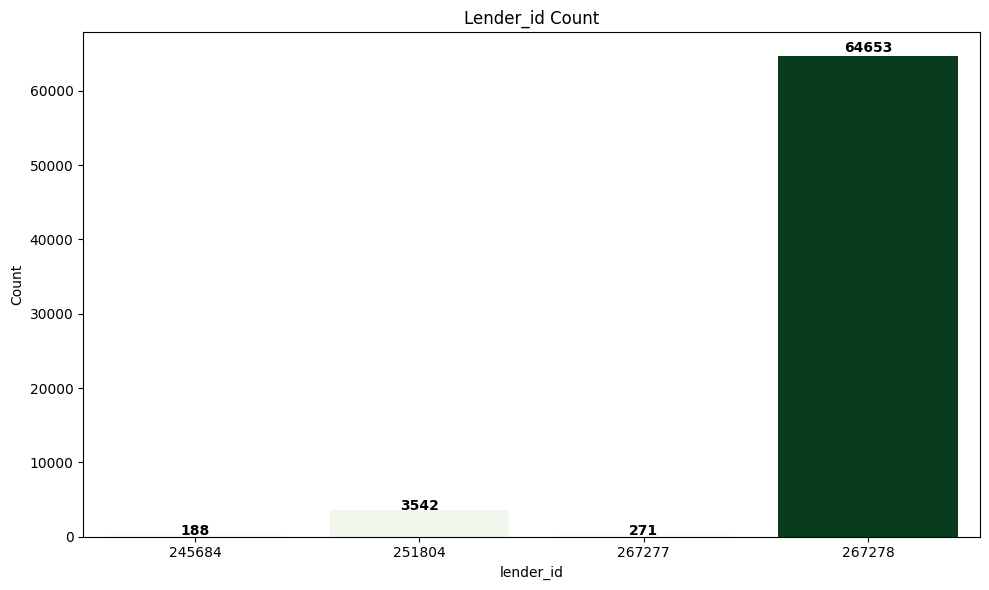

In [29]:
#let's see how many times each lender has been patronized

fig, axes = plt.subplots(1, 1, figsize=(10, 6))

column = 'lender_id'
title = 'Lender_id Count'

# Get the counts for each lender_id
counts = df1[column].value_counts().sort_index()

# Create a colormap where the highest value gets dark green and the others are lighter
norm = plt.Normalize(counts.min(), counts.max())
cmap = plt.cm.Greens

sns.countplot(x=column, data=df1, ax=axes, palette=cmap(norm(counts.values)))
axes.set_title(title)
axes.set_xlabel(column)
axes.set_ylabel('Count')

# Add annotations for the count above each bar
for i, val in enumerate(counts):
    axes.text(i, val + 0.01 * val, f'{val}', ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()


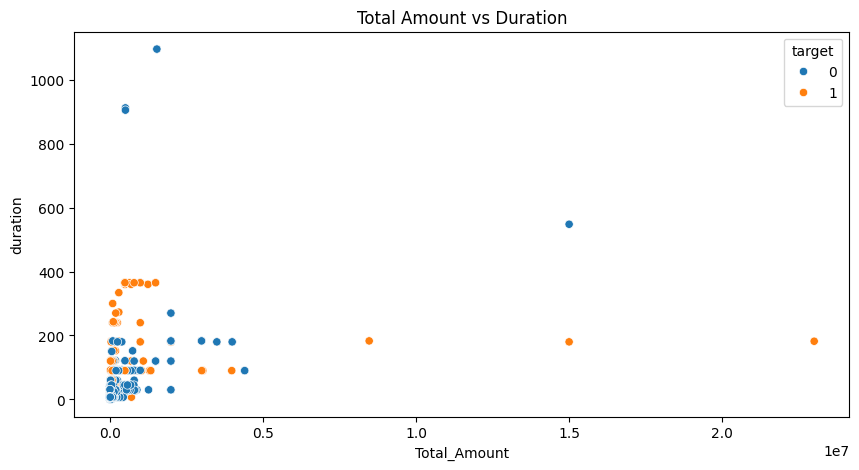

In [30]:
#Lets look at the relationship between amount loaned and the time it takes to repay the loan
plt.figure(figsize=(10,5))

sns.scatterplot(x='Total_Amount', y='duration', data=df1, hue='target')
plt.title('Total Amount vs Duration')
plt.show()

It appears that while customers who default and those who successfully repay their loans generally borrow within the same range of amounts, there is a noticeable difference in the loan durations. Specifically, customers who default tend to have longer loan durations compared to their counterparts who repay successfully.

This suggests that longer loan durations might be a contributing factor to defaults, potentially indicating that extended repayment periods could be creating more opportunities for financial strain or making it harder for customers to keep up with their payments.

In [12]:
temporal_features = ['disbursement_date', 'due_date']

#create date features year, month, day
df1['disbursement_year'] = df1['disbursement_date'].dt.year
df1['disbursement_month'] = df1['disbursement_date'].dt.month
df1['disbursement_day'] = df1['disbursement_date'].dt.day

df2['disbursement_year'] = df2['disbursement_date'].dt.year
df2['disbursement_month'] = df2['disbursement_date'].dt.month
df2['disbursement_day'] = df2['disbursement_date'].dt.day


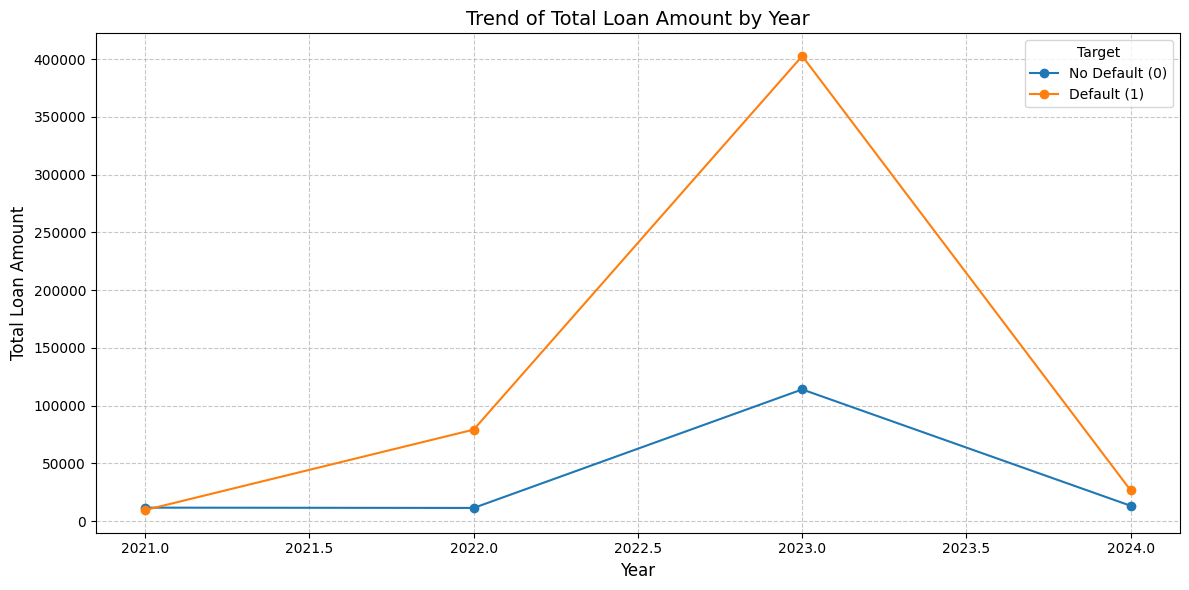

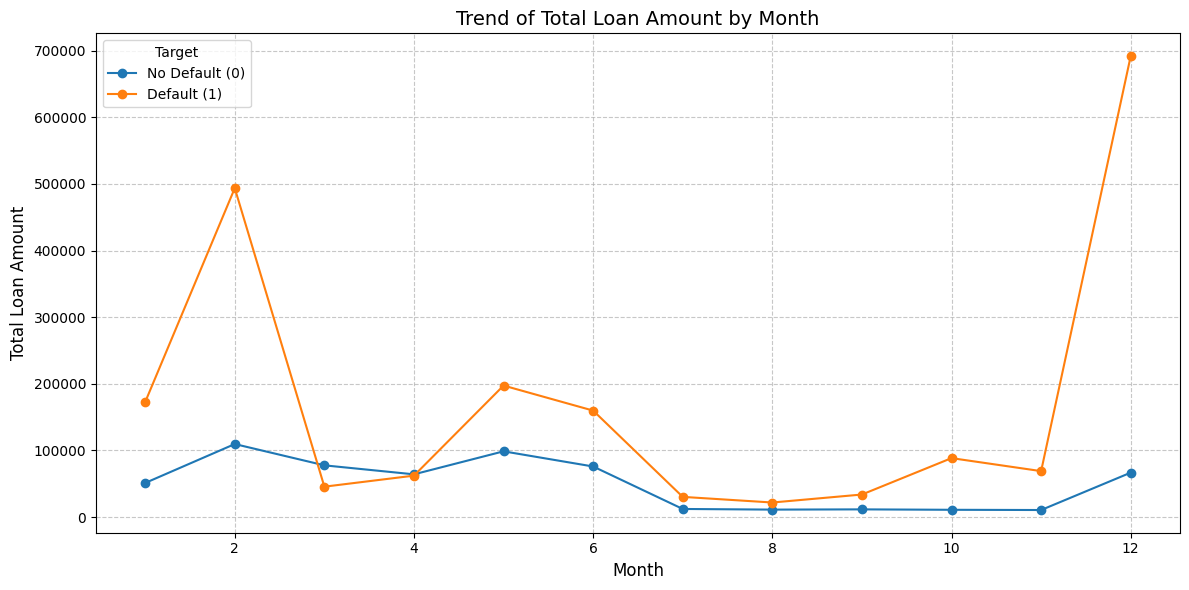

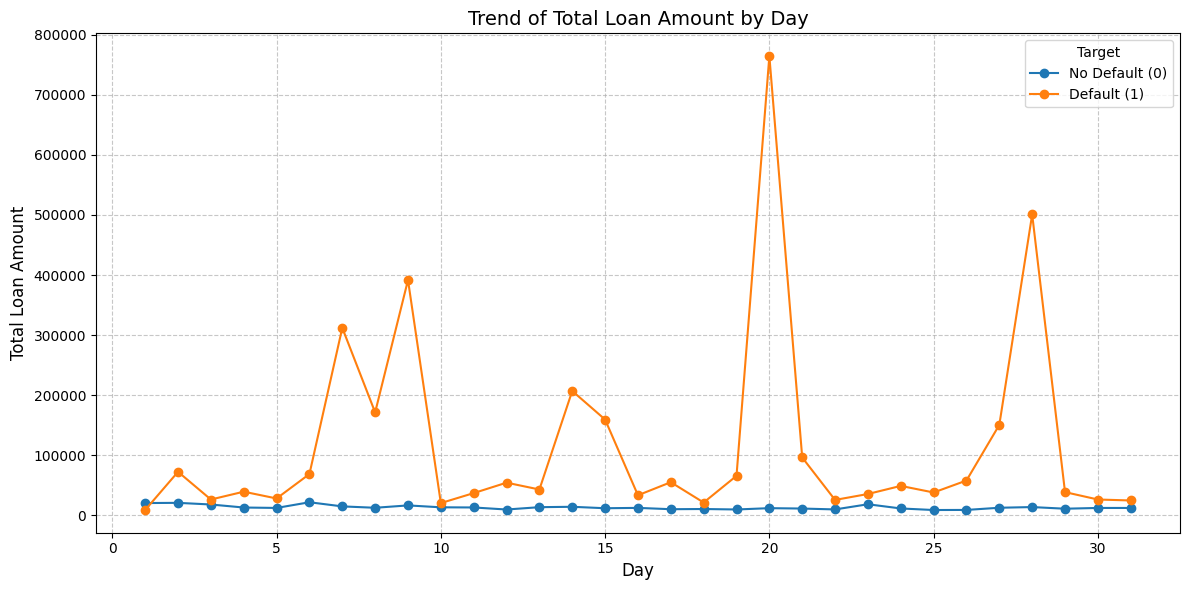

In [32]:
# Function to plot trends for Total Amount loaned
def plot_trends(data, time_col, target_col, value_col, time_label):
    grouped = data.groupby([time_col, target_col])[value_col].mean().unstack()
    grouped.plot(kind='line', figsize=(12, 6), marker='o')
    plt.title(f'Trend of Total Loan Amount by {time_label}', fontsize=14)
    plt.xlabel(time_label, fontsize=12)
    plt.ylabel('Total Loan Amount', fontsize=12)
    plt.legend(['No Default (0)', 'Default (1)'], title='Target', fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Plot yearly trends
plot_trends(df1, 'disbursement_year', 'target', 'Total_Amount', 'Year')

# Plot monthly trends
plot_trends(df1, 'disbursement_month', 'target', 'Total_Amount', 'Month')

# Plot daily trends
plot_trends(df1, 'disbursement_day', 'target', 'Total_Amount', 'Day')



It appears that the loan amounts of customers who defaulted tend to increase around February and December. This suggests that during these months, there might be a spike in the loan amounts taken by customers who ultimately struggle to repay.

The correlation between higher loan amounts and specific months raises a few questions. It could be related to seasonal financial pressures, holiday spending, or other factors influencing borrowing behavior during these times. The increased loan amounts could be contributing to a higher risk of defaults, as customers may find it harder to repay larger loans.

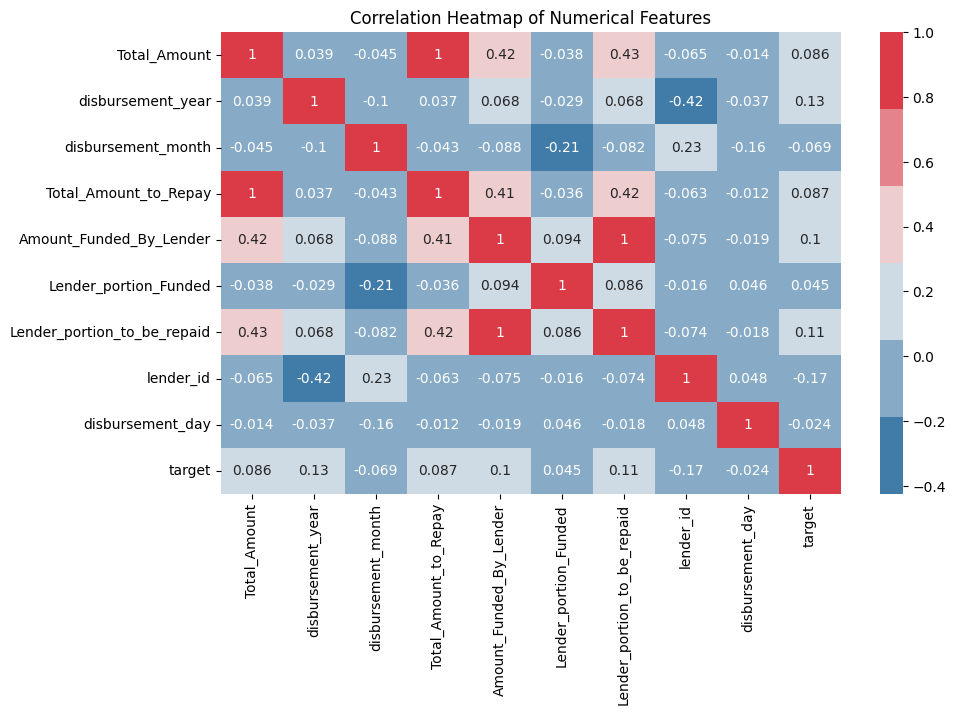

In [141]:
#Heatmap Correlation of Numeric features
Num_features = ['Total_Amount','disbursement_year','disbursement_month', 'Total_Amount_to_Repay', 'Amount_Funded_By_Lender',
       'Lender_portion_Funded', 'Lender_portion_to_be_repaid', 'lender_id', 'disbursement_day', 'target']

plt.figure(figsize=(10,6))
sns.heatmap(df1[Num_features].corr(), annot=True, cbar=True, cmap=sns.diverging_palette(240,10))
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

Three features stand out as being slightly correlated with the likelihood of default:



*  Lender Portion to be Repaid
*  Amount Funded by Lender
*  Disbursement Year

While these correlations are not very strong, they do suggest that these features have some influence on the target variable.

# **Enriching the data with economic indicators**

In [13]:
# Define the list of critical indicators
critical_indicators = [
    "Official exchange rate (LCU per US$, period average)",
    "Real interest rate (%)",
    "Lending interest rate (%)",
    "Average precipitation in depth (mm per year)",
    "Deposit interest rate (%)",
    "Inflation, consumer prices (annual %)",
    "Fossil fuel energy consumption (% of total)",
    "Interest rate spread (lending rate minus deposit rate, %)",
    "Unemployment rate"
]

# Filter the data for these indicators
df4_filtered = df4[df4['Indicator'].isin(critical_indicators)]
df4_filtered.head()

,Country,Indicator,YR2001,YR2002,YR2003,YR2004,YR2005,YR2006,YR2007,YR2008,...,YR2014,YR2015,YR2016,YR2017,YR2018,YR2019,YR2020,YR2021,YR2022,YR2023
0,Ghana,"Inflation, consumer prices (annual %)",41.509496,9.360932,29.772980,18.042739,15.438992,11.679184,10.734267,16.494640,...,15.489616,17.149970,17.454635,12.371922,7.808765,7.143640,9.887290,9.971089,31.255895,38.106966
1,Cote d'Ivoire,"Inflation, consumer prices (annual %)",4.361529,3.077265,3.296807,1.457988,3.885830,2.467191,1.892006,6.308528,...,0.448682,1.251500,0.723178,0.685881,0.359409,-1.106863,2.425007,4.091952,5.276167,4.387117
2,Kenya,"Inflation, consumer prices (annual %)",5.738598,1.961308,9.815691,11.624036,10.312778,14.453734,9.758880,26.239817,...,6.878155,6.582154,6.297250,8.005650,4.689806,5.239638,5.405162,6.107936,7.659863,7.671396
3,Ghana,"Official exchange rate (LCU per US$, period av...",0.716305,0.792417,0.866764,0.899495,0.905209,0.915107,0.932619,1.052275,...,2.896575,3.714642,3.909817,4.350533,4.585325,5.217367,5.595708,5.805700,8.272400,11.020408
4,Cote d'Ivoire,"Official exchange rate (LCU per US$, period av...",732.397693,693.713226,579.897426,527.338032,527.258363,522.425625,478.633718,446.000041,...,493.757330,591.211698,592.605615,580.656750,555.446458,585.911013,575.586005,554.530675,623.759701,606.569750


In [14]:
#Reshape the filtered economic data

df4_long = pd.melt(df4_filtered, id_vars=["Country", "Indicator"], var_name="Year", value_name="Value")

# Extract the year as an integer
df4_long['Year'] = df4_long['Year'].str.replace('YR', '').astype(int)
df4_long.head()

,Country,Indicator,Year,Value
0,Ghana,"Inflation, consumer prices (annual %)",2001,41.509496
1,Cote d'Ivoire,"Inflation, consumer prices (annual %)",2001,4.361529
2,Kenya,"Inflation, consumer prices (annual %)",2001,5.738598
3,Ghana,"Official exchange rate (LCU per US$, period av...",2001,0.716305
4,Cote d'Ivoire,"Official exchange rate (LCU per US$, period av...",2001,732.397693


In [15]:
# Lets Pivot the data to have indicators as columns
df4_pivoted = df4_long.pivot_table(
    index=["Country", "Year"],
    columns="Indicator",
    values="Value"
).reset_index()

# Remove the MultiIndex
df4_pivoted.columns.name = None
df4_pivoted

,Country,Year,Average precipitation in depth (mm per year),Deposit interest rate (%),Fossil fuel energy consumption (% of total),"Inflation, consumer prices (annual %)","Interest rate spread (lending rate minus deposit rate, %)",Lending interest rate (%),"Official exchange rate (LCU per US$, period average)",Real interest rate (%),Unemployment rate
0,Cote d'Ivoire,2001,1348.0,NaN,34.298397,4.361529,NaN,NaN,732.397693,NaN,5.199
1,Cote d'Ivoire,2002,1348.0,NaN,37.848716,3.077265,NaN,NaN,693.713226,NaN,5.516
2,Cote d'Ivoire,2003,1348.0,NaN,32.501441,3.296807,NaN,NaN,579.897426,NaN,5.858
3,Cote d'Ivoire,2004,1348.0,NaN,24.930573,1.457988,NaN,NaN,527.338032,NaN,5.930
4,Cote d'Ivoire,2005,1348.0,7.607500,25.391257,3.885830,-0.558333,7.049167,527.258363,5.763991,6.041
...,...,...,...,...,...,...,...,...,...,...,...
64,Kenya,2019,630.0,7.506070,NaN,5.239638,4.935063,12.441133,101.991298,7.831101,5.014
65,Kenya,2020,630.0,6.968703,NaN,5.405162,5.027081,11.995785,106.450780,6.714634,5.621
66,Kenya,2021,630.0,6.686974,NaN,6.107936,5.393025,12.079998,109.637747,7.427581,5.693
67,Kenya,2022,NaN,7.145176,NaN,7.659863,5.190665,12.335841,117.865989,5.968447,5.805


In [16]:
# Merge the economic data with train and test datasets
df1_enriched = pd.merge(
    df1,
    df4_pivoted,
    how='left',
    left_on=['country_id', 'disbursement_year'],
    right_on=['Country', 'Year']
)

df2_enriched = pd.merge(
    df2,
    df4_pivoted,
    how='left',
    left_on=['country_id', 'disbursement_year'],
    right_on=['Country', 'Year']
)

# Drop unnecessary columns after the merge (optional)
df1_enriched.drop(columns=['Country', 'Year'], inplace=True)
df2_enriched.drop(columns=['Country', 'Year'], inplace=True)
display('df1_enriched', df1_enriched)
display('df2_enriched', df2_enriched)

'df1_enriched'

,ID,customer_id,country_id,tbl_loan_id,lender_id,loan_type,Total_Amount,Total_Amount_to_Repay,disbursement_date,due_date,...,disbursement_day,Average precipitation in depth (mm per year),Deposit interest rate (%),Fossil fuel energy consumption (% of total),"Inflation, consumer prices (annual %)","Interest rate spread (lending rate minus deposit rate, %)",Lending interest rate (%),"Official exchange rate (LCU per US$, period average)",Real interest rate (%),Unemployment rate
0,ID_266671248032267278,266671,Kenya,248032,267278,Type_1,8448.0,8448.0,2022-08-30,2022-09-06,...,30,NaN,7.145176,NaN,7.659863,5.190665,12.335841,117.865989,5.968447,5.805
1,ID_248919228515267278,248919,Kenya,228515,267278,Type_1,25895.0,25979.0,2022-07-30,2022-08-06,...,30,NaN,7.145176,NaN,7.659863,5.190665,12.335841,117.865989,5.968447,5.805
2,ID_308486370501251804,308486,Kenya,370501,251804,Type_7,6900.0,7142.0,2024-09-06,2024-09-13,...,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ID_266004285009267278,266004,Kenya,285009,267278,Type_1,8958.0,9233.0,2022-10-20,2022-10-27,...,20,NaN,7.145176,NaN,7.659863,5.190665,12.335841,117.865989,5.968447,5.805
4,ID_253803305312267278,253803,Kenya,305312,267278,Type_1,4564.0,4728.0,2022-11-28,2022-12-05,...,28,NaN,7.145176,NaN,7.659863,5.190665,12.335841,117.865989,5.968447,5.805
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62237,ID_244559228408267278,244559,Kenya,228408,267278,Type_1,1460.0,1515.0,2022-07-30,2022-08-06,...,30,NaN,7.145176,NaN,7.659863,5.190665,12.335841,117.865989,5.968447,5.805
62238,ID_260062217784267278,260062,Kenya,217784,267278,Type_1,5029.0,5116.0,2022-07-16,2022-07-23,...,16,NaN,7.145176,NaN,7.659863,5.190665,12.335841,117.865989,5.968447,5.805
62239,ID_259137216701267278,259137,Kenya,216701,267278,Type_1,5289.0,5289.0,2022-07-15,2022-07-22,...,15,NaN,7.145176,NaN,7.659863,5.190665,12.335841,117.865989,5.968447,5.805
62240,ID_266801303201267278,266801,Kenya,303201,267278,Type_1,3334.0,3334.0,2022-11-23,2022-11-30,...,23,NaN,7.145176,NaN,7.659863,5.190665,12.335841,117.865989,5.968447,5.805


'df2_enriched'

,ID,customer_id,country_id,tbl_loan_id,lender_id,loan_type,Total_Amount,Total_Amount_to_Repay,disbursement_date,due_date,...,disbursement_day,Average precipitation in depth (mm per year),Deposit interest rate (%),Fossil fuel energy consumption (% of total),"Inflation, consumer prices (annual %)","Interest rate spread (lending rate minus deposit rate, %)",Lending interest rate (%),"Official exchange rate (LCU per US$, period average)",Real interest rate (%),Unemployment rate
0,ID_269404226088267278,269404,Kenya,226088,267278,Type_1,1919.00,1989.00,2022-07-27,2022-08-03,...,27,NaN,7.145176,NaN,7.659863,5.190665,12.335841,117.865989,5.968447,5.805
1,ID_255356300042267278,255356,Kenya,300042,267278,Type_1,2138.00,2153.00,2022-11-16,2022-11-23,...,16,NaN,7.145176,NaN,7.659863,5.190665,12.335841,117.865989,5.968447,5.805
2,ID_257026243764267278,257026,Kenya,243764,267278,Type_1,8254.00,8304.00,2022-08-24,2022-08-31,...,24,NaN,7.145176,NaN,7.659863,5.190665,12.335841,117.865989,5.968447,5.805
3,ID_264617299409267278,264617,Kenya,299409,267278,Type_1,3379.00,3379.00,2022-11-15,2022-11-22,...,15,NaN,7.145176,NaN,7.659863,5.190665,12.335841,117.865989,5.968447,5.805
4,ID_247613296713267278,247613,Kenya,296713,267278,Type_1,120.00,120.00,2022-11-10,2022-11-17,...,10,NaN,7.145176,NaN,7.659863,5.190665,12.335841,117.865989,5.968447,5.805
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18589,ID_297596365331297183,297596,Ghana,365331,297183,Type_3,1730.41,1782.32,2023-02-09,2023-02-16,...,9,NaN,11.416667,NaN,38.106966,NaN,NaN,11.020408,NaN,3.079
18590,ID_259715231897267278,259715,Kenya,231897,267278,Type_1,1534.00,1534.00,2022-08-04,2022-08-11,...,4,NaN,7.145176,NaN,7.659863,5.190665,12.335841,117.865989,5.968447,5.805
18591,ID_296701364008297183,296701,Ghana,364008,297183,Type_3,1372.21,1413.30,2022-06-23,2022-06-30,...,23,NaN,12.052083,NaN,31.255895,NaN,NaN,8.272400,NaN,3.084
18592,ID_268271242864267278,268271,Kenya,242864,267278,Type_1,5608.00,5781.00,2022-08-23,2022-08-30,...,23,NaN,7.145176,NaN,7.659863,5.190665,12.335841,117.865989,5.968447,5.805


In [17]:
#Rename columns

df1_enriched.rename(columns={'Official exchange rate (LCU per US$, period average)': 'Official_exchange_rate',
                             'Real interest rate (%)': 'Real_interest_rate', 'Average precipitation in depth (mm per year)': 'Average_precipitation',
                             'Deposit interest rate (%)': 'Deposit_interest_rate', 'Inflation, consumer prices (annual %)': 'Inflation',
                             'Fossil fuel energy consumption (% of total)': 'Fossil_fuel_energy_consumption',
                             'Interest rate spread (lending rate minus deposit rate, %)': 'Interest_rate_spread',
                             'Unemployment rate': 'Unemployment_rate', 'Lending interest rate (%)':'Lending interest rate'}, inplace=True)

df2_enriched.rename(columns={'Official exchange rate (LCU per US$, period average)': 'Official_exchange_rate',
                             'Real interest rate (%)': 'Real_interest_rate', 'Average precipitation in depth (mm per year)': 'Average_precipitation',
                             'Deposit interest rate (%)': 'Deposit_interest_rate', 'Inflation, consumer prices (annual %)': 'Inflation',
                             'Fossil fuel energy consumption (% of total)': 'Fossil_fuel_energy_consumption',
                             'Interest rate spread (lending rate minus deposit rate, %)': 'Interest_rate_spread',
                             'Unemployment rate': 'Unemployment_rate', 'Lending interest rate (%)':'Lending interest rate'}, inplace=True)


In [94]:
df1_enriched.head(2)

,ID,customer_id,country_id,tbl_loan_id,lender_id,loan_type,Total_Amount,Total_Amount_to_Repay,disbursement_date,due_date,...,target,disbursement_year,disbursement_month,disbursement_day,Deposit_interest_rate,Inflation,Interest_rate_spread,Lending interest rate,Official_exchange_rate,Unemployment_rate
0,ID_266671248032267278,266671,Kenya,248032,267278,Type_1,8448.0,8448.0,2022-08-30,2022-09-06,...,0,2022,8,30,7.145176,7.659863,5.190665,12.335841,117.865989,5.805
1,ID_248919228515267278,248919,Kenya,228515,267278,Type_1,25895.0,25979.0,2022-07-30,2022-08-06,...,0,2022,7,30,7.145176,7.659863,5.190665,12.335841,117.865989,5.805


In [95]:
df2_enriched.head(2)

,ID,customer_id,country_id,tbl_loan_id,lender_id,loan_type,Total_Amount,Total_Amount_to_Repay,disbursement_date,due_date,...,Lender_portion_to_be_repaid,disbursement_year,disbursement_month,disbursement_day,Deposit_interest_rate,Inflation,Interest_rate_spread,Lending interest rate,Official_exchange_rate,Unemployment_rate
0,ID_269404226088267278,269404,Kenya,226088,267278,Type_1,1919.0,1989.0,2022-07-27,2022-08-03,...,597.0,2022,7,27,7.145176,7.659863,5.190665,12.335841,117.865989,5.805
1,ID_255356300042267278,255356,Kenya,300042,267278,Type_1,2138.0,2153.0,2022-11-16,2022-11-23,...,0.0,2022,11,16,7.145176,7.659863,5.190665,12.335841,117.865989,5.805


In [18]:
#Average_precipitation, Fossil_fuel_energy_consumption are empty columns so we'll remove them

df1_enriched = df1_enriched.drop(['Average_precipitation','Fossil_fuel_energy_consumption',
                                  'Real_interest_rate'], axis=1)
df2_enriched = df2_enriched.drop(['Average_precipitation','Fossil_fuel_energy_consumption',
                                  'Real_interest_rate'], axis=1)

In [19]:
#Fill missing values

def fill_missing_values(df1_enriched, df2_enriched):

    train_fill_values = {
        'Lending interest rate': 17.15,
        'Deposit_interest_rate': 11.85,
        'Inflation': 2.72,
        'Official_exchange_rate': 129.439,
        'Unemployment_rate': 5.7
    }
    df1_enriched.loc[df1_enriched['disbursement_year'] == 2024, train_fill_values.keys()] = df1_enriched.loc[df1_enriched['disbursement_year'] == 2024, train_fill_values.keys()].fillna(train_fill_values)

    df1_enriched['Interest_rate_spread'] = df1_enriched['Lending interest rate'] - df1_enriched['Deposit_interest_rate']

    # Fill missing values in the Test dataset for Ghana customers (2022-2024)
    ghana_conditions = df2_enriched['country_id'] == 'Ghana'

    ghana_fill_values = {
        2021: {
            'Lending interest rate': 26.34,

        },
        2022: {
            'Lending interest rate': 31.40,

        },
        2023: {
            'Lending interest rate': 31.15,

        },
        2024: {
            'Lending interest rate': 31.10,
            'Deposit_interest_rate': 11.00,
            'Inflation': 19.53,
            'Official_exchange_rate': 15.9834,
            'Unemployment_rate': 4.0
        }
    }

    for year, values in ghana_fill_values.items():
        conditions = ghana_conditions & (df2_enriched['disbursement_year'] == year)
        df2_enriched.loc[conditions, values.keys()] = df2_enriched.loc[conditions, values.keys()].fillna(values)

    # Fill missing values in the Test dataset for Kenya customers (2024 only)
    kenya_conditions = (df2_enriched['country_id'] == 'Kenya') & (df2_enriched['disbursement_year'] == 2024)

    kenya_fill_values = {
        'Lending interest rate': 17.15,
        'Deposit_interest_rate': 11.85,
        'Inflation': 2.72,
        'Official_exchange_rate': 129.439,
        'Unemployment_rate': 5.7
    }
    df2_enriched.loc[kenya_conditions, kenya_fill_values.keys()] = df2_enriched.loc[kenya_conditions, kenya_fill_values.keys()].fillna(kenya_fill_values)
    df2_enriched['Interest_rate_spread'] = df2_enriched['Lending interest rate'] - df2_enriched['Deposit_interest_rate']

    return df1_enriched, df2_enriched


In [20]:
df1_enriched, df2_enriched = fill_missing_values(df1_enriched, df2_enriched)

In [ ]:
#Mutual information to check for important features
from sklearn.feature_selection import mutual_info_classif

mi_data = df1_enriched.copy()

y_tg = mi_data['target']
X_ft = mi_data.drop(['target','ID','customer_id','tbl_loan_id','country_id','disbursement_date','due_date'], axis=1)
le = LabelEncoder()
X_ft['loan_type'] = le.fit_transform(X_ft['loan_type'])
X_ft['New_versus_Repeat'] = le.fit_transform(X_ft['New_versus_Repeat'])


In [ ]:
# Calculate mutual information
mi_scores = mutual_info_classif(X_ft, y_tg, random_state=11)
mi_scores = pd.Series(mi_scores, index=X_ft.columns)
mi_scores = mi_scores.sort_values(ascending=False)

print(mi_scores)

lender_id                      0.027669
Lender_portion_Funded          0.025446
disbursement_year              0.020883
duration                       0.019927
Interest_rate_spread           0.018976
Unemployment_rate              0.018236
loan_type                      0.018001
New_versus_Repeat              0.017629
Lending interest rate          0.017564
Inflation                      0.017068
Deposit_interest_rate          0.016230
Official_exchange_rate         0.014677
Total_Amount_to_Repay          0.014317
Amount_Funded_By_Lender        0.014242
Lender_portion_to_be_repaid    0.014063
Total_Amount                   0.012824
disbursement_month             0.010281
disbursement_day               0.000518
dtype: float64


# Data Preprocessing

In [21]:
df1_enriched.shape, df2_enriched.shape

((62242, 25), (18594, 24))

In [ ]:
#Removing outliers didn't improve my model

'''def remove_outliers_iqr(df, columns):
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

df1_enriched = remove_outliers_iqr(df1_enriched, Numerical_features)'''


# Features Engineering

In [22]:
#Drop target
y = df1_enriched['target']
train_df = df1_enriched.drop(['target'], axis=1)

In [23]:
#Drop unnecessary columns

train_df = train_df.drop(['ID','country_id','tbl_loan_id','disbursement_date', 'due_date', 'New_versus_Repeat'], axis=1)
test_df = df2_enriched.drop(['ID','country_id','tbl_loan_id','disbursement_date', 'due_date', 'New_versus_Repeat'], axis=1)

In [24]:
#Encoding categorical features

combined_df = pd.concat([train_df, test_df], sort=False)


encoder = LabelEncoder()
combined_df['loan_type'] = encoder.fit_transform(combined_df['loan_type'])
combined_df['lender_id'] = encoder.fit_transform(combined_df['lender_id'])

In [25]:
#creating new features


combined_df['Loan_to_interest_rate'] = combined_df['Total_Amount'] * combined_df['Lending interest rate']
combined_df['Repayment_ratio'] = combined_df['Total_Amount_to_Repay'] / combined_df['Total_Amount']
combined_df['Interest_rate'] = (combined_df['Total_Amount_to_Repay'] - combined_df['Total_Amount']) / combined_df['Total_Amount']
# Replace negative values with zero in a feature
combined_df['Interest_rate'] = combined_df['Interest_rate'].apply(lambda x: max(x, 0))
combined_df['interest_rate_of_lender'] = (combined_df['Lender_portion_to_be_repaid'] - combined_df['Amount_Funded_By_Lender']) / combined_df['Amount_Funded_By_Lender']
# Replace negative values with zero in a feature
combined_df['interest_rate_of_lender'] = combined_df['interest_rate_of_lender'].apply(lambda x: max(x, 0))

#=====================================================================================================================#

combined_df['Amount_diff'] = combined_df['Total_Amount_to_Repay'] - combined_df['Total_Amount']
#Replace negative values with zero
combined_df['Amount_diff'] = combined_df['Amount_diff'].apply(lambda x: max(x, 0))
combined_df['Lender_diff'] = combined_df['Lender_portion_to_be_repaid'] - combined_df['Amount_Funded_By_Lender']
combined_df['Lender_diff'] = combined_df['Lender_diff'].apply(lambda x: max(x, 0))

In [26]:
combined_df.shape

(80836, 24)

In [27]:
#fill rows where the lender has no interest with zero

combined_df['interest_rate_of_lender'].fillna(0,inplace=True)

In [160]:
missing_entries = combined_df[combined_df.isnull().any(axis=1)]
missing_entries.head()

,customer_id,lender_id,loan_type,Total_Amount,Total_Amount_to_Repay,duration,Amount_Funded_By_Lender,Lender_portion_Funded,Lender_portion_to_be_repaid,disbursement_year,...,Interest_rate_spread,Lending interest rate,Official_exchange_rate,Unemployment_rate,Loan_to_interest_rate,Repayment_ratio,Interest_rate,interest_rate_of_lender,Amount_diff,Lender_diff


In [28]:
#log transform to address skewness

combined_df['Total_Amount'] = np.log1p(combined_df['Total_Amount'])
combined_df['Lender_portion_Funded'] = np.log1p(combined_df['Lender_portion_Funded'])
combined_df['Repayment_ratio'] = np.log1p(combined_df['Repayment_ratio'])
combined_df['Interest_rate'] = np.log1p(combined_df['Interest_rate'])
combined_df['interest_rate_of_lender'] = np.log1p(combined_df['interest_rate_of_lender'])
combined_df['Loan_to_interest_rate'] = np.log1p(combined_df['Loan_to_interest_rate'])
combined_df['Amount_diff'] = np.log1p(combined_df['Amount_diff'])
combined_df['Lender_diff'] = np.log1p(combined_df['Lender_diff'])

In [29]:
#create a cluster list and use unsupervised learning to potentially discover some patterns

cluster_list = ['lender_id','duration','loan_type','disbursement_year',
                 'Interest_rate', 'interest_rate_of_lender']

In [30]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

comb_cluster = combined_df[cluster_list]
scaler = StandardScaler()
comb_cluster_scaled = scaler.fit_transform(comb_cluster)

wcss = []
silhoutte_scores = []

for k in range(2,11):
  kmeans = KMeans(n_clusters=k, init='k-means++', random_state=67)
  kmeans.fit(comb_cluster_scaled)
  wcss.append(kmeans.inertia_)
  silhoutte_scores.append(silhouette_score(comb_cluster_scaled, kmeans.labels_))


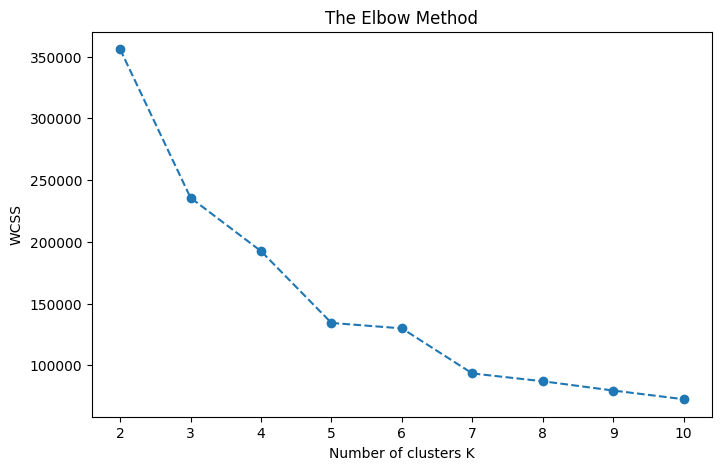

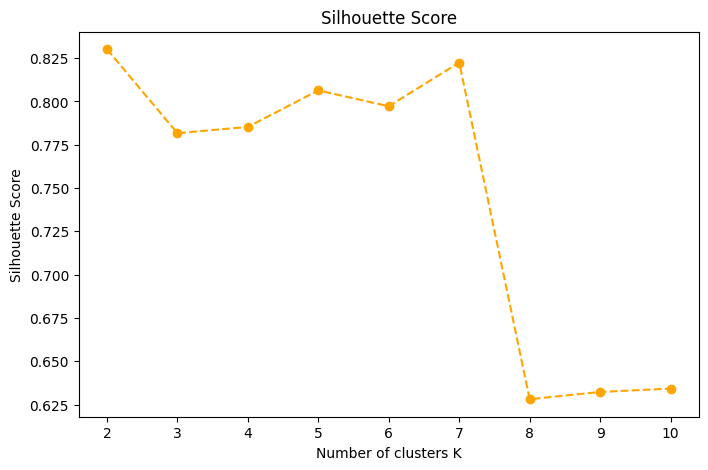

In [31]:
plt.figure(figsize=(8,5))
plt.plot(range(2,11), wcss, marker='o', linestyle='--')
plt.title('The Elbow Method')
plt.xlabel('Number of clusters K')
plt.ylabel('WCSS')
plt.show()

plt.figure(figsize=(8,5))
plt.plot(range(2,11), silhoutte_scores, marker='o', linestyle='--', color='orange', label='Silhoutte Score')
plt.title('Silhouette Score')
plt.xlabel('Number of clusters K')
plt.ylabel('Silhouette Score')
plt.show()

In [32]:
#split original data back to train and test

Train = combined_df.iloc[:len(y), :]
Test = combined_df.iloc[len(y):, :]
print('Train Shape: ',Train.shape, end='\n\n')
print('Test Shape: ',Test.shape, end='\n\n')

Train Shape:  (62242, 24)

Test Shape:  (18594, 24)



In [33]:
optimal_k = 7
kmeans = KMeans(n_clusters=optimal_k, init='k-means++', random_state=17)#17
comb_cluster['cluster'] = kmeans.fit_predict(comb_cluster_scaled)

In [34]:
Train_with_clust = comb_cluster.iloc[:len(y), :]
Test_with_clust = comb_cluster.iloc[len(y):, :]
print('Train with clust Shape: ',Train_with_clust.shape, end='\n\n')
print('Test with clust Shape: ',Test_with_clust.shape, end='\n\n')

Train with clust Shape:  (62242, 7)

Test with clust Shape:  (18594, 7)



In [35]:
Train['cluster'] = Train_with_clust['cluster']
Test['cluster'] = Test_with_clust['cluster']

In [36]:
Train.shape, Test.shape

((62242, 25), (18594, 25))

In [223]:
Train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 62242 entries, 0 to 62241
Data columns (total 26 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   customer_id                  62242 non-null  int64  
 1   lender_id                    62242 non-null  int64  
 2   loan_type                    62242 non-null  int64  
 3   Total_Amount                 62242 non-null  float64
 4   Total_Amount_to_Repay        62242 non-null  float64
 5   duration                     62242 non-null  int64  
 6   Amount_Funded_By_Lender      62242 non-null  float64
 7   Lender_portion_Funded        62242 non-null  float64
 8   Lender_portion_to_be_repaid  62242 non-null  float64
 9   disbursement_year            62242 non-null  int32  
 10  disbursement_month           62242 non-null  int32  
 11  disbursement_day             62242 non-null  int32  
 12  Deposit_interest_rate        62242 non-null  float64
 13  Inflation            

In [37]:
#Drop unimportant and one of highly correlated features

Train = Train.drop(['Unemployment_rate','Interest_rate_spread','Inflation','Deposit_interest_rate','Official_exchange_rate',
                    'Total_Amount_to_Repay','Amount_Funded_By_Lender','Lending interest rate'], axis=1)
Test = Test.drop(['Unemployment_rate','Interest_rate_spread','Inflation','Deposit_interest_rate','Official_exchange_rate',
                  'Total_Amount_to_Repay','Amount_Funded_By_Lender','Lending interest rate'], axis=1)

In [38]:
Train.shape, Test.shape

((62242, 17), (18594, 17))

In [ ]:
#Addressing class imbalance with SMOTENN
#from imblearn.combine import SMOTEENN
#smote_enn = SMOTEENN(random_state=20) #25
#train_resampled, y_resampled = smote_enn.fit_resample(Train, y) #Didn't perform well as class weights

In [ ]:
#y_resampled.value_counts()

,count
target,
1,50654
0,48505


# **Model Training**

In [39]:
#y = y
class_weights = calculate_class_weights(y)
print(class_weights)

{0: 0.5097958916227108, 1: 26.020903010033443}


In [40]:
#Splitting the training data into train and validation sets
#X_train, X_val, y_train, y_val = train_test_split(train_resampled, y_resampled, test_size=0.2, random_state=11, stratify=y_resampled)
X_train, X_val, y_train, y_val = train_test_split(Train, y, test_size=0.2, random_state=11, stratify=y)
#random_state=11

In [41]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((49793, 17), (12449, 17), (49793,), (12449,))

In [42]:
#Define group labels for stratified groupkfold cross validation
group_labels = X_train['customer_id']

In [43]:
# Drop customer_id after creating group labels
X_train = X_train.drop(columns=['customer_id'])
X_val = X_val.drop(columns=['customer_id'])
Test = Test.drop(columns=['customer_id'])

In [44]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((49793, 16), (12449, 16), (49793,), (12449,))

In [49]:
class_names = ['Class 0', 'Class 1']

In [79]:
#xgboost stratified group kfold cross validation

xgboost_model = xgb.XGBClassifier(n_estimators=900,max_depth=12,learning_rate=0.007,
                                       alpha=0.7,subsample=0.6682761162470723,
                                        class_weights=class_weights,random_state=20)
mean_f1_xgboost = stratified_groupkfold_cv(xgboost_model, X_train, y_train, groups=group_labels, n_splits=10,
                                           class_weights=class_weights, verbose=True)
# Print the mean F1-score across folds
print(f"Mean F1-Score across folds (XgBoost): {mean_f1_xgboost:.4f}")

Fold 1/10
F1 Score: 0.8541
Fold 2/10
F1 Score: 0.8791
Fold 3/10
F1 Score: 0.9128
Fold 4/10
F1 Score: 0.8136
Fold 5/10
F1 Score: 0.7867
Fold 6/10
F1 Score: 0.8866
Fold 7/10
F1 Score: 0.7742
Fold 8/10
F1 Score: 0.7879
Fold 9/10
F1 Score: 0.8370
Fold 10/10
F1 Score: 0.7805
Mean F1 Score: 0.8312
Mean F1-Score across folds (XgBoost): 0.8312


In [80]:
#Fit and make predictions on validation data
xgboost_model.fit(X_train, y_train)
xgboost_val_pred = xgboost_model.predict(X_val)
print(classification_report(y_val, xgboost_val_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12210
           1       0.92      0.85      0.89       239

    accuracy                           1.00     12449
   macro avg       0.96      0.93      0.94     12449
weighted avg       1.00      1.00      1.00     12449



In [91]:
#calculate metric scores

xgb_score = f1_score(y_val, xgboost_val_pred)
xgb_auc_score = roc_auc_score(y_val, xgboost_val_pred)
xgb_acc_score = accuracy_score(y_val, xgboost_val_pred)
xgb_prec_score = precision_score(y_val, xgboost_val_pred)
xgb_recall_score = recall_score(y_val, xgboost_val_pred)
print(f"F1 Score: {xgb_score}")
print(f"AUC Score: {xgb_auc_score}")
print(f"Accuracy Score: {xgb_acc_score}")
print(f"Precision Score: {xgb_prec_score}")
print(f"Recall Score: {xgb_recall_score}")

F1 Score: 0.8850325379609545
AUC Score: 0.9260411419407234
Accuracy Score: 0.9957426299301149
Precision Score: 0.918918918918919
Recall Score: 0.8535564853556485


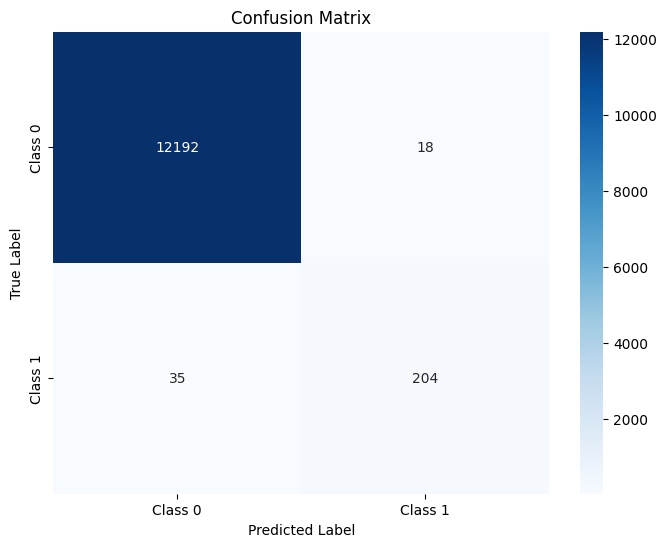

In [82]:
#Visualize confusion matrix

plot_confusion_matrix(y_val, xgboost_val_pred, class_names)

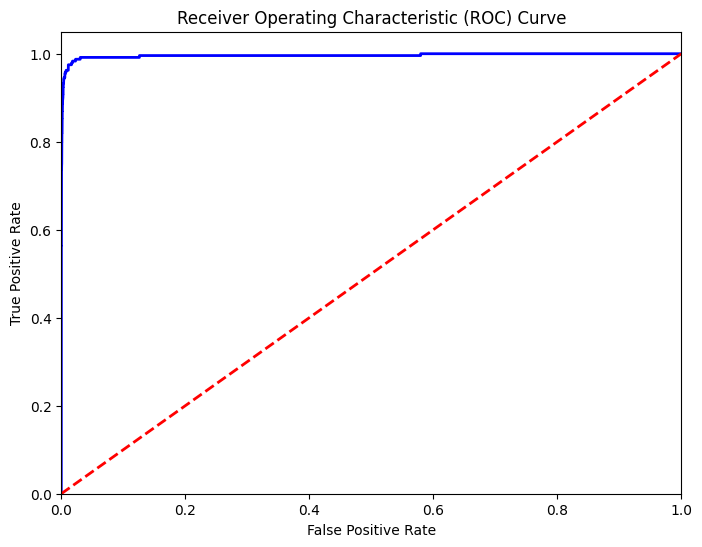

In [89]:
# plot ROC curve
y_prob = xgboost_model.predict_proba(X_val)[:, 1]
fpr, tpr, thresholds = roc_curve(y_val, y_prob)
roc_auc = auc(fpr, tpr)


plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.show()

In [83]:
#make predictions
xgboost_pred = xgboost_model.predict(Test)
xgboost_sub = df3[['ID']]
xgboost_sub['target'] = xgboost_pred
xgboost_sub.to_csv('xgboost_sub_african.csv', index=False)

In [84]:
xgboost_sub['target'].value_counts()

,count
target,
0,17886
1,708


In [92]:
#A Little magic trick i learnt from one of the participants in the challenge @VincentSchuler
# which involves post processing the predictions. Honestly i don't know how he came about the conclusion or
# what he noticed in the data to come up with this idea.
# Essentially what he did here was to set the target to 1 if the following 2 conditions are met:
# 1. if the loan_type is loan_type_3
# 2. The last loan taken by each customer

data2['target'] = xgboost_pred

# Identify the last loan for each customer based on loan_id
data2['is_last_loan'] = data2.groupby('customer_id')['tbl_loan_id'].transform('max') == data2['tbl_loan_id']

# The conditions
condition_1 = (data2['loan_type'] == 'Type_3')
condition_2 = data2['is_last_loan']

# Update the target column based on the conditions
data2.loc[condition_1 & condition_2, 'target'] = 1
data2.drop(columns=['is_last_loan'], inplace=True)

In [87]:
updated_sub = data2[['ID', 'target']]
updated_sub.to_csv('updated_sub.csv', index=False)

In [88]:
updated_sub['target'].value_counts()

,count
target,
0,17507
1,1087


***And it worked!***


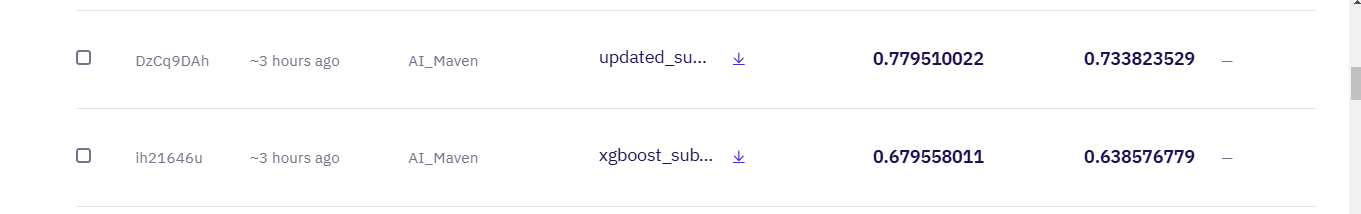

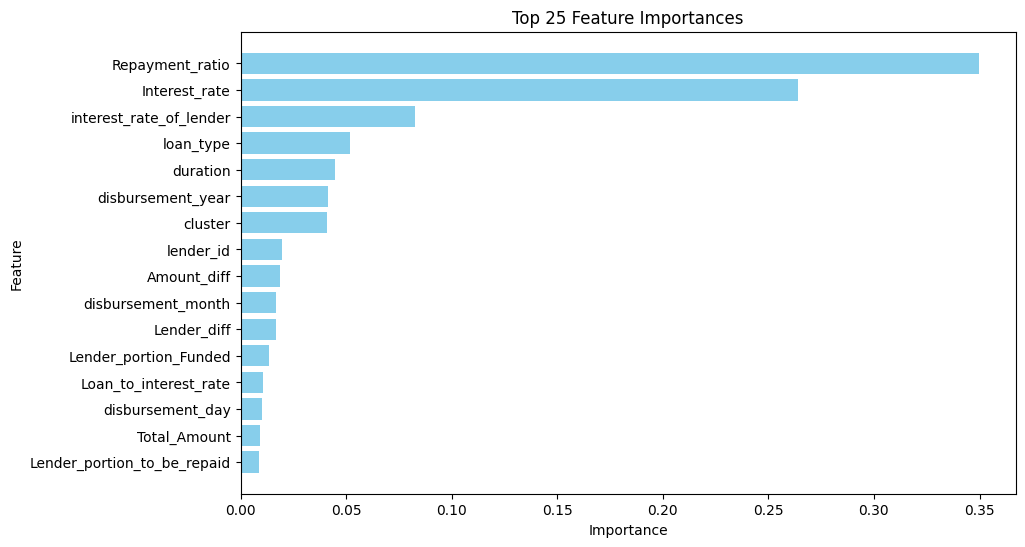

In [55]:
visualize_feature_importance(xgboost_model, X_train.columns)

The model considers the repayment ratio, interest rate, and interest rate of lender as the top 3 important features.

Let's look at Shap

**Feature Importance with Shap**

Bar plot

In [57]:
import shap

In [58]:
explainer = shap.Explainer(xgboost_model, X_train)

In [59]:
# Compute SHAP values for test set
shap_values = explainer(X_val)

100%|===================| 12406/12449 [05:18<00:01]       

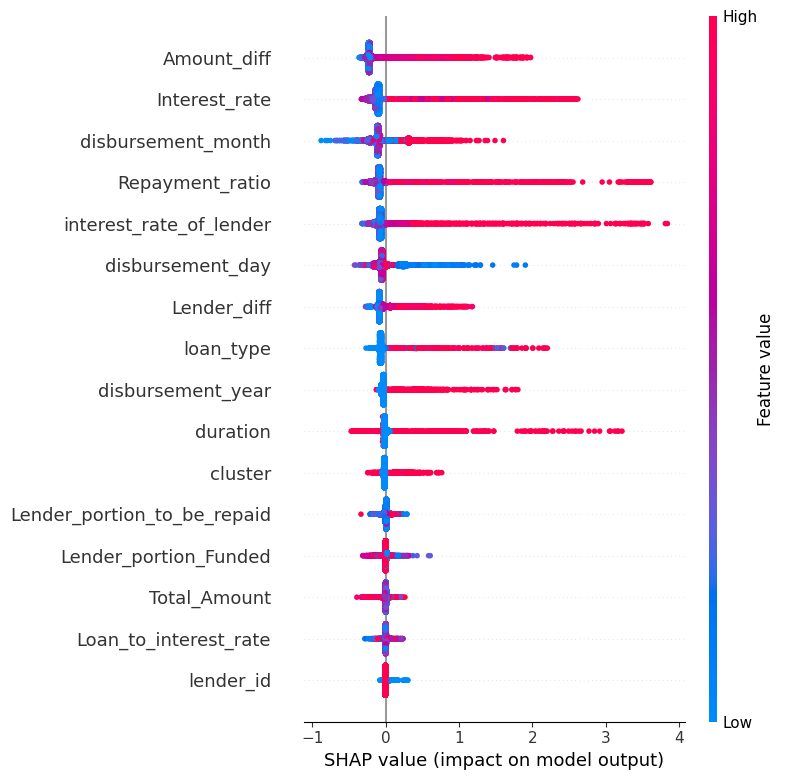

In [60]:
shap.summary_plot(shap_values, X_val, max_display=30)

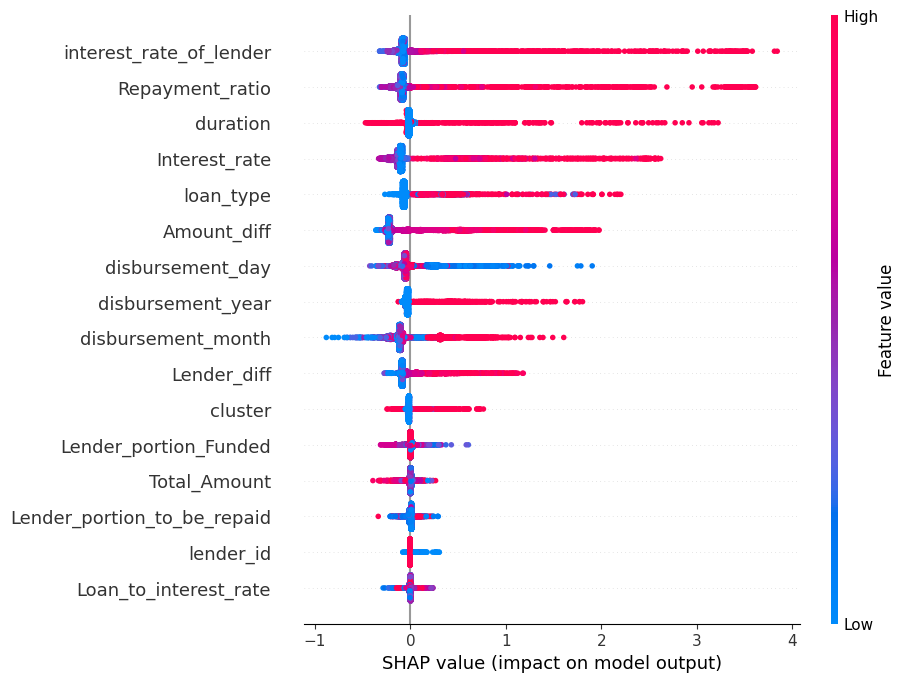

In [61]:
shap.plots.beeswarm(shap_values, order=shap_values.abs.max(0), max_display=30)

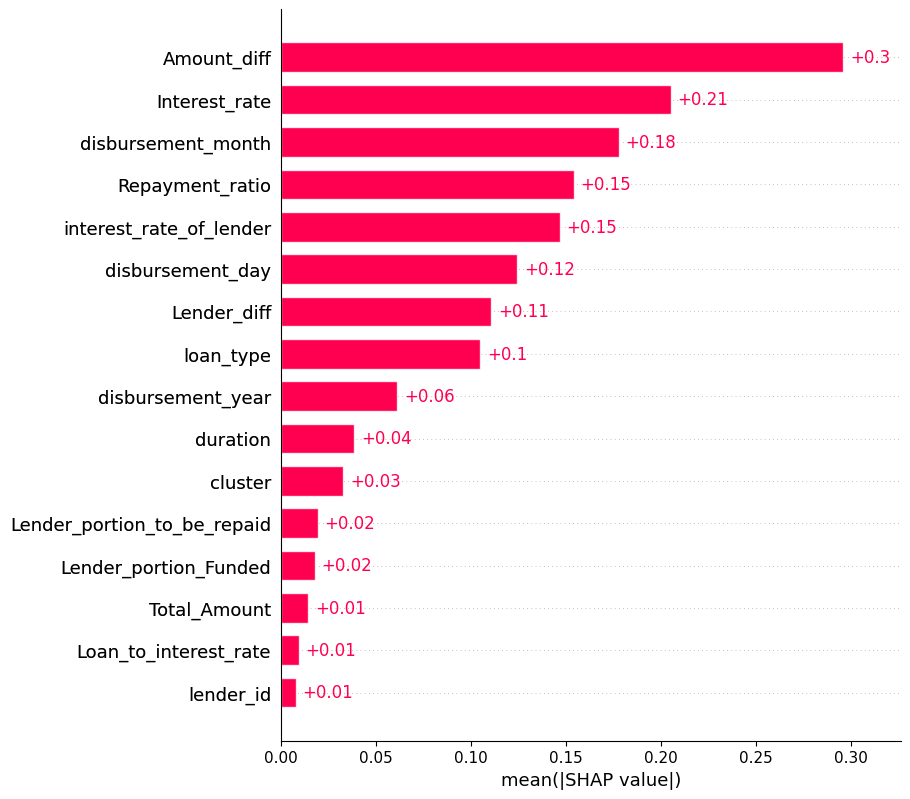

In [62]:
shap.plots.bar(shap_values.abs.mean(0), max_display=30)

With shap feature importance, Amount diff (The difference between Total Amount loaned and Total Amount to repay) as the most important feature

Hyper-Parameter Tuning with Optuna

In [65]:
# Suggest hyperparameters
def objective(trial):
  param = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "max_depth": trial.suggest_int("max_depth", 10, 15),
        "learning_rate": trial.suggest_float("learning_rate", 0.009, 0.1, log=True),
        "alpha": trial.suggest_float("alpha", 0, 10.0),
        "subsample": trial.suggest_float("subsample", 0.0, 1.0),
        "random_state": 11,
    }

  model_xgb = xgb.XGBClassifier(**param, class_weight=class_weights, eval_metric='logloss')
  mean_f1 = stratified_groupkfold_cv(model_xgb, X_train, y_train, groups=group_labels, n_splits=10,
                                       class_weights=class_weights, verbose=False)

  return mean_f1

# Create study and optimize
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# Print best parameters
print("Best Hyperparameters:", study.best_params)
print("Best F1 Score:", study.best_value)

[I 2025-01-14 18:51:59,123] A new study created in memory with name: no-name-b7975402-5c0b-4272-a141-2919cce6c2b8
[I 2025-01-14 18:53:19,405] Trial 0 finished with value: 0.8377130275151348 and parameters: {'n_estimators': 724, 'max_depth': 12, 'learning_rate': 0.0685987621611532, 'alpha': 5.864280806214893, 'subsample': 0.6593385806402943}. Best is trial 0 with value: 0.8377130275151348.
[I 2025-01-14 18:53:43,058] Trial 1 finished with value: 0.8052849723052242 and parameters: {'n_estimators': 349, 'max_depth': 11, 'learning_rate': 0.010276496753970372, 'alpha': 3.9723795307795795, 'subsample': 0.24101947150049075}. Best is trial 0 with value: 0.8377130275151348.
[I 2025-01-14 18:54:31,310] Trial 2 finished with value: 0.8373019796856 and parameters: {'n_estimators': 510, 'max_depth': 10, 'learning_rate': 0.016545309700246317, 'alpha': 0.010262404164972372, 'subsample': 0.8239207075718542}. Best is trial 0 with value: 0.8377130275151348.
[I 2025-01-14 18:54:52,584] Trial 3 finished w

Best Hyperparameters: {'n_estimators': 607, 'max_depth': 12, 'learning_rate': 0.06912356362620622, 'alpha': 5.544588290622663, 'subsample': 0.5730203503666051}
Best F1 Score: 0.8423235403813155


In [66]:
#xgboost
xgboost_tuned_model = xgb.XGBClassifier(n_estimators=607,max_depth=12,learning_rate=0.0691235636262062,
                                        alpha=5.544588290622663,subsample=0.5730203503666051,
                                        class_weights=class_weights,random_state=11)
mean_f1 = stratified_groupkfold_cv(xgboost_tuned_model, X_train, y_train, groups=group_labels, n_splits=10,
                                           class_weights=class_weights, verbose=True)
# Print the mean F1-score across folds
print(f"Mean F1-Score across folds (XgBoost): {mean_f1:.4f}")


Fold 1/10
F1 Score: 0.8649
Fold 2/10
F1 Score: 0.8865
Fold 3/10
F1 Score: 0.9137
Fold 4/10
F1 Score: 0.8427
Fold 5/10
F1 Score: 0.8079
Fold 6/10
F1 Score: 0.9101
Fold 7/10
F1 Score: 0.7598
Fold 8/10
F1 Score: 0.8049
Fold 9/10
F1 Score: 0.8387
Fold 10/10
F1 Score: 0.7941
Mean F1 Score: 0.8423
Mean F1-Score across folds (XgBoost): 0.8423


In [68]:
tuned_xgboost_val_pred = xgboost_tuned_model.predict(X_val)
print(classification_report(y_val, tuned_xgboost_val_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12210
           1       0.91      0.81      0.86       239

    accuracy                           0.99     12449
   macro avg       0.95      0.91      0.93     12449
weighted avg       0.99      0.99      0.99     12449



In [69]:
xgb_score = f1_score(y_val, tuned_xgboost_val_pred)
print(f"F1 Score: {xgb_score}")

F1 Score: 0.8584070796460177


In [ ]:
xgboost_pred = xgboost_tuned_model.predict(Test)
xgboost_sub = df3[['ID']]
xgboost_sub['target'] = xgboost_pred
xgboost_sub.to_csv('xgboost_sub_african34.csv', index=False)
